In [11]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import parent
import data
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import network_wrappers

import numpy as np

from sklearn.decomposition import PCA
from mermaidlite import compute_warped_image_multiNC, identity_map_multiN



In [71]:
D = 32
triangles = data.get_dataset_triangles("train", data_size=D, samples=6000, hollow=False)
triangles = torch.cat([tensors[0] for tensors in triangles[0]])

In [72]:
t_flat = np.array(torch.reshape(triangles, (6000, D**2)))
n_components=512
tpca = PCA(n_components=n_components)
tpca.fit(t_flat)

t_transformed = torch.tensor(tpca.transform(t_flat))

t_transformed_normalized = torch.tensor(
    t_transformed / np.sqrt(torch.mean(t_transformed**2, axis=0, keepdims=True)))


/playpen-raid1/tgreer/anaconda3/envs/mermaid5/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


In [107]:
t_transformed_normalized = torch.tensor(t_flat[:, ::2])
t_transformed_normalized.shape

torch.Size([6000, 512])

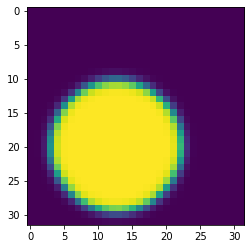

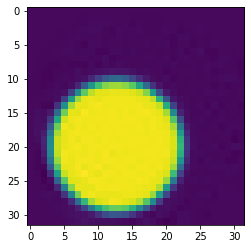

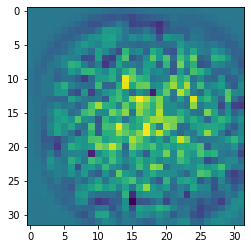

In [102]:
plt.imshow(triangles[90, 0])
plt.show()
plt.imshow(tpca.inverse_transform(t_transformed[90]).reshape(D,D))
plt.show()
plt.imshow(tpca.inverse_transform(t_transformed_normalized[90]).reshape(D,D))



In [119]:
class InverseConsistentNet(nn.Module):
    def __init__(self, network, similarity, lmbda):

        super(InverseConsistentNet, self).__init__()

        self.regis_net = network
        self.lmbda = lmbda
        self.similarity = similarity

    def forward(self, image_A, image_B):
        image_A_t, image_A = image_A
        image_B_t, image_B = image_B
        # Tag used elsewhere for optimization.
        # Must be set at beginning of forward b/c not preserved by .cuda() etc
        self.identityMap.isIdentity = True

        self.phi_AB = self.regis_net(image_A_t, image_B_t)
        self.phi_BA = self.regis_net(image_B_t, image_A_t)

        self.phi_AB_vectorfield = self.phi_AB(self.identityMap)
        self.phi_BA_vectorfield = self.phi_BA(self.identityMap)

        self.warped_image_A = compute_warped_image_multiNC(
            image_A, self.phi_AB_vectorfield, self.spacing, 1
        )
        self.warped_image_B = compute_warped_image_multiNC(
            image_B, self.phi_BA_vectorfield, self.spacing, 1
        )

        similarity_loss = self.similarity(
            self.warped_image_A, image_B
        ) + self.similarity(self.warped_image_B, image_A)

        Iepsilon = (
            self.identityMap
            + torch.randn(*self.identityMap.shape).cuda()
            * 1
            / self.identityMap.shape[-1]
        )

        # inverse consistency one way

        approximate_Iepsilon1 = self.phi_AB(self.phi_BA(Iepsilon))

        approximate_Iepsilon2 = self.phi_BA(self.phi_AB(Iepsilon))
        
        inverse_consistency_loss = torch.mean(
            (Iepsilon - approximate_Iepsilon1) ** 2
        ) + torch.mean((Iepsilon - approximate_Iepsilon2) ** 2)

        transform_magnitude = torch.mean(
            (self.identityMap - self.phi_AB_vectorfield) ** 2
        )

        all_loss = self.lmbda * inverse_consistency_loss + similarity_loss

        return (
            all_loss,
            inverse_consistency_loss,
            similarity_loss,
            transform_magnitude,
        )
class PCA_FCNet(nn.Module):
    def __init__(self, size=28):
        super(PCA_FCNet, self).__init__()
        self.size = size
        self.dense1 = nn.Linear(n_components * 2, 5120)
        self.dense2 = nn.Linear(5120, 5120)
        self.dense3 = nn.Linear(5120, size * size * 2)
        torch.nn.init.zeros_(self.dense3.weight)
        torch.nn.init.zeros_(self.dense3.bias)

    def forward(self, x, y):
        
        x = torch.cat([x, y], 1)
        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))
        x = self.dense3(x)
        x = torch.reshape(x, (-1, 2, self.size, self.size))
        return x

In [120]:
net = InverseConsistentNet(
    network_wrappers.FunctionFromVectorField(
        PCA_FCNet(size=D)
    ),
    lambda x, y: torch.mean((x - y)**2),
    256
)

In [121]:
BATCH_SIZE = 128
input_shape = [BATCH_SIZE, 1, D, D]
net.assign_identity_map(input_shape)
net.cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
net.train()

InverseConsistentNet(
  (regis_net): FunctionFromVectorField(
    (net): PCA_FCNet(
      (dense1): Linear(in_features=1024, out_features=5120, bias=True)
      (dense2): Linear(in_features=5120, out_features=5120, bias=True)
      (dense3): Linear(in_features=5120, out_features=2048, bias=True)
    )
  )
)

In [122]:
loss_history = []
for _ in range(100000):
    for _ in range(100):
        index = np.random.randint(0, len(triangles), BATCH_SIZE)
        batch_full_A = triangles[index].cuda()
        batch_transformed_A = t_transformed_normalized[index].cuda()
        index2 = np.random.randint(0, len(triangles), BATCH_SIZE)
        batch_full_B = triangles[index2].cuda()
        batch_transformed_B = t_transformed_normalized[index2].cuda()
        batch = ((batch_transformed_A, batch_full_A), (batch_transformed_B, batch_full_B))
        optimizer.zero_grad()
        loss = net(*batch)
        loss[0].backward()
        optimizer.step()
        loss_history.append([l.item() for l in loss])
    print([l.item() for l in loss])
    


[1.2364823818206787, 6.1683269450441e-05, 1.220691442489624, 1.1172956874361262e-05]
[1.2393158674240112, 0.00011242457549087703, 1.2105351686477661, 3.0633404094260186e-05]
[1.6994082927703857, 0.0016569250728935003, 1.2752354145050049, 0.0002860031963791698]
[1.197514533996582, 6.416349060600623e-05, 1.1810886859893799, 1.605731449672021e-05]
[1.1958434581756592, 6.227506673894823e-05, 1.1799010038375854, 1.6309189959429204e-05]
[1.2207615375518799, 6.34649841231294e-05, 1.204514503479004, 1.6985704860417172e-05]
[2.3541579246520996, 0.004462377168238163, 1.2117893695831299, 0.0006592849968001246]
[1.3656212091445923, 6.129372195573524e-05, 1.3499300479888916, 2.0061052055098116e-05]
[1.3251392841339111, 6.382285937434062e-05, 1.3088005781173706, 2.089396002702415e-05]
[1.189422845840454, 6.370535993482918e-05, 1.17311429977417, 2.0781673811143264e-05]
[1.2528561353683472, 6.437173578888178e-05, 1.2363770008087158, 2.119417695212178e-05]
[1.2446863651275635, 6.351880438160151e-05, 1.

[1.192708134651184, 6.486220081569627e-05, 1.1761033535003662, 2.854101694538258e-05]
[1.2413461208343506, 6.368620961438864e-05, 1.225042462348938, 2.831629171851091e-05]
[1.1378912925720215, 6.82517493260093e-05, 1.1204187870025635, 2.9545542929554358e-05]
[1.218778133392334, 6.223769742064178e-05, 1.2028453350067139, 2.7787016733782366e-05]
[1.2175805568695068, 6.94690243108198e-05, 1.199796438217163, 2.9475409974111244e-05]
[1.2473881244659424, 7.02419929439202e-05, 1.2294061183929443, 2.9240192816359922e-05]
[1.2385011911392212, 6.883365131216124e-05, 1.2208797931671143, 2.920371844084002e-05]
[1.2456097602844238, 6.658764323219657e-05, 1.2285633087158203, 2.905966539401561e-05]
[1.2521493434906006, 6.831876817159355e-05, 1.2346597909927368, 2.94925212074304e-05]
[1.338670253753662, 6.702465179841965e-05, 1.32151198387146, 2.923301508417353e-05]
[1.2087910175323486, 6.778345414204523e-05, 1.1914384365081787, 2.939793557743542e-05]
[1.246566891670227, 6.927362846909091e-05, 1.22883

[1.2111222743988037, 6.54041359666735e-05, 1.1943788528442383, 3.2179632398765534e-05]
[1.2805495262145996, 6.892075180076063e-05, 1.2629058361053467, 3.231558366678655e-05]
[1.2405543327331543, 6.532588304253295e-05, 1.2238309383392334, 3.183708031428978e-05]
[1.3186924457550049, 6.143948121462017e-05, 1.3029639720916748, 3.095499414484948e-05]
[1.294826626777649, 6.750477041350678e-05, 1.27754545211792, 3.1865842174738646e-05]
[1.3123245239257812, 7.24221026757732e-05, 1.293784499168396, 3.2593503419775516e-05]
[1.2431906461715698, 6.449846841860563e-05, 1.2266790866851807, 3.181939973728731e-05]
[1.2633085250854492, 6.623062654398382e-05, 1.2463535070419312, 3.214396565454081e-05]
[1.2636622190475464, 6.837271939730272e-05, 1.2461588382720947, 3.253085378673859e-05]
[1.2745054960250854, 6.615118763875216e-05, 1.257570743560791, 3.1814819521969184e-05]
[1.1692047119140625, 6.556508014909923e-05, 1.1524200439453125, 3.214207026758231e-05]
[1.2260385751724243, 6.705975829390809e-05, 1.

[1.2606383562088013, 6.602858775295317e-05, 1.2437350749969482, 3.253492832300253e-05]
[1.199130654335022, 6.594270234927535e-05, 1.1822493076324463, 3.257775824749842e-05]
[1.3254340887069702, 6.399489211617038e-05, 1.3090513944625854, 3.252603346481919e-05]
[1.2783340215682983, 6.529125676024705e-05, 1.2616194486618042, 3.254831972299144e-05]
[1.2156853675842285, 6.782117998227477e-05, 1.198323130607605, 3.2278290746035054e-05]
[1.1925642490386963, 6.784027209505439e-05, 1.1751971244812012, 3.2870964787434787e-05]
[1.3463047742843628, 6.514094275189564e-05, 1.3296287059783936, 3.1736322853248566e-05]
[1.273230791091919, 6.407141336239874e-05, 1.2568285465240479, 3.229661888326518e-05]
[1.3808411359786987, 6.68820139253512e-05, 1.3637193441390991, 3.226396074751392e-05]
[1.2585906982421875, 6.623741501243785e-05, 1.2416338920593262, 3.2421681680716574e-05]
[1.3183908462524414, 6.732782640028745e-05, 1.3011549711227417, 3.307915903860703e-05]
[1.1947354078292847, 6.864713213872164e-05,

[1.2449454069137573, 6.591960845980793e-05, 1.2280700206756592, 3.399328124942258e-05]
[1.3428300619125366, 6.305564602371305e-05, 1.3266878128051758, 3.31588089466095e-05]
[1.2416539192199707, 6.760983524145558e-05, 1.2243458032608032, 3.399961497052573e-05]
[1.265413522720337, 6.294550985330716e-05, 1.2492995262145996, 3.340078183100559e-05]
[1.2440896034240723, 6.741907418472692e-05, 1.2268303632736206, 3.411865691305138e-05]
[1.229730486869812, 6.668113201158121e-05, 1.2126600742340088, 3.427713818382472e-05]
[1.307896375656128, 6.661268707830459e-05, 1.2908434867858887, 3.398206899873912e-05]
[1.195942759513855, 6.494763511000201e-05, 1.1793161630630493, 3.3360731322318316e-05]
[1.2601959705352783, 6.737954390700907e-05, 1.2429468631744385, 3.3962565794354305e-05]
[1.197853684425354, 6.79478034726344e-05, 1.1804590225219727, 3.4131913707824424e-05]
[1.3267239332199097, 6.339477840811014e-05, 1.3104948997497559, 3.323691271361895e-05]
[1.165157675743103, 6.829973426647484e-05, 1.14

[1.204453945159912, 6.49255161988549e-05, 1.1878330707550049, 3.5054414183832705e-05]
[1.2610212564468384, 6.639116327278316e-05, 1.2440251111984253, 3.543297134456225e-05]
[1.195399284362793, 6.459662836277857e-05, 1.1788625717163086, 3.445563925197348e-05]
[1.3153603076934814, 6.42487284494564e-05, 1.2989126443862915, 3.4732707717921585e-05]
[1.2525675296783447, 6.724651757394895e-05, 1.2353523969650269, 3.5854376619681716e-05]
[1.1507234573364258, 6.374357326421887e-05, 1.1344051361083984, 3.477112841210328e-05]
[1.1671887636184692, 6.510941602755338e-05, 1.1505208015441895, 3.5094693885184824e-05]
[1.2405576705932617, 6.60916994092986e-05, 1.2236381769180298, 3.501158789731562e-05]
[1.2578356266021729, 6.469707295764238e-05, 1.2412731647491455, 3.481146995909512e-05]
[1.2405260801315308, 6.51432346785441e-05, 1.2238494157791138, 3.5390366974752396e-05]
[1.2597553730010986, 7.062946679070592e-05, 1.2416741847991943, 3.623046359280124e-05]
[1.1859610080718994, 6.488697545137256e-05, 

[1.3590298891067505, 7.158784137573093e-05, 1.3407033681869507, 3.633592132246122e-05]
[1.2286531925201416, 6.579702312592417e-05, 1.2118091583251953, 3.579181066015735e-05]
[1.2331079244613647, 6.437685078708455e-05, 1.2166274785995483, 3.5750839742831886e-05]
[1.2726707458496094, 6.626531830988824e-05, 1.255706787109375, 3.565154111129232e-05]
[1.305144190788269, 6.616825703531504e-05, 1.2882051467895508, 3.5713324905373156e-05]
[1.2649180889129639, 6.385029701050371e-05, 1.2485724687576294, 3.5882447264157236e-05]
[1.1278636455535889, 6.442972517106682e-05, 1.1113696098327637, 3.56360396835953e-05]
[1.217332124710083, 6.43575913272798e-05, 1.2008565664291382, 3.5979741369374096e-05]
[1.2945818901062012, 6.64594117552042e-05, 1.2775682210922241, 3.631274012150243e-05]
[1.2730991840362549, 6.669762660749257e-05, 1.2560245990753174, 3.590864798752591e-05]
[1.2435972690582275, 6.795550143579021e-05, 1.2262006998062134, 3.627591650001705e-05]
[1.1489431858062744, 6.940511229913682e-05, 1

[1.3276509046554565, 6.709295848850161e-05, 1.3104751110076904, 3.663139068521559e-05]
[1.160907506942749, 6.805063458159566e-05, 1.143486499786377, 3.677687709569e-05]
[1.2439721822738647, 6.429533823393285e-05, 1.2275125980377197, 3.659392677946016e-05]
[1.2498562335968018, 6.400412530638278e-05, 1.233471155166626, 3.578163523343392e-05]
[1.247054934501648, 7.098404603311792e-05, 1.2288830280303955, 3.707308496814221e-05]
[1.2846368551254272, 6.779682007618248e-05, 1.2672808170318604, 3.694201950565912e-05]
[1.2887873649597168, 6.364515138557181e-05, 1.2724941968917847, 3.574427682906389e-05]
[1.2001837491989136, 6.661931547569111e-05, 1.1831291913986206, 3.644446769612841e-05]
[1.2013063430786133, 6.822032446507365e-05, 1.1838419437408447, 3.644801472546533e-05]
[1.286571979522705, 6.511433457490057e-05, 1.2699027061462402, 3.649922291515395e-05]
[1.286930799484253, 6.104308704379946e-05, 1.2713037729263306, 3.538643068168312e-05]
[1.190906047821045, 6.691696762572974e-05, 1.1737753

[1.2220470905303955, 6.824541924288496e-05, 1.2045762538909912, 3.753920827875845e-05]
[1.220283031463623, 6.869164644740522e-05, 1.202697992324829, 3.733573976205662e-05]
[1.2652678489685059, 6.521475734189153e-05, 1.248572826385498, 3.714194463100284e-05]
[1.2423001527786255, 6.407029286492616e-05, 1.2258981466293335, 3.682154419948347e-05]
[1.2935107946395874, 6.77537900628522e-05, 1.2761658430099487, 3.707977884914726e-05]
[1.2530053853988647, 6.717636279063299e-05, 1.235808253288269, 3.729598392965272e-05]
[1.2852184772491455, 6.685522384941578e-05, 1.2681034803390503, 3.719648520927876e-05]
[1.2121620178222656, 6.783877324778587e-05, 1.1947952508926392, 3.7271049222908914e-05]
[1.248087763786316, 6.551522528752685e-05, 1.2313158512115479, 3.6902558349538594e-05]
[1.2981070280075073, 6.50963993393816e-05, 1.281442403793335, 3.655723776319064e-05]
[1.3074314594268799, 6.484633922809735e-05, 1.2908308506011963, 3.6761255614692345e-05]
[1.223343849182129, 6.506426143459976e-05, 1.206

[1.211862564086914, 6.234914326341823e-05, 1.1959011554718018, 3.7061672628624365e-05]
[1.2519280910491943, 6.488440703833476e-05, 1.2353177070617676, 3.688791912281886e-05]
[1.2960052490234375, 6.397583638317883e-05, 1.2796274423599243, 3.6497367545962334e-05]
[1.1993188858032227, 6.673475581919774e-05, 1.182234764099121, 3.7186749977990985e-05]
[1.156079649925232, 6.771049811504781e-05, 1.1387457847595215, 3.746704896911979e-05]
[1.3005735874176025, 6.991921691223979e-05, 1.2826743125915527, 3.846663094009273e-05]
[1.2403419017791748, 6.975056021474302e-05, 1.2224857807159424, 3.8246864278335124e-05]
[1.3108209371566772, 6.675871554762125e-05, 1.2937307357788086, 3.760649269679561e-05]
[1.1799588203430176, 6.538041634485126e-05, 1.1632214784622192, 3.786642992054112e-05]
[1.2661046981811523, 6.598123582080007e-05, 1.249213457107544, 3.781548366532661e-05]
[1.2135192155838013, 6.676785415038466e-05, 1.1964266300201416, 3.804015796049498e-05]
[1.1759059429168701, 6.427153130061924e-05,

[1.1594362258911133, 6.695710908388719e-05, 1.142295241355896, 3.7873680412303656e-05]
[1.1546926498413086, 6.688241410301998e-05, 1.1375707387924194, 3.754256249521859e-05]
[1.2024081945419312, 6.689739529974759e-05, 1.1852824687957764, 3.759950050152838e-05]
[1.2722069025039673, 6.782817945349962e-05, 1.2548428773880005, 3.813923831330612e-05]
[1.2601717710494995, 6.13841402810067e-05, 1.244457483291626, 3.6379620723892e-05]
[1.1960937976837158, 6.590590055566281e-05, 1.1792218685150146, 3.790856499108486e-05]
[1.1216247081756592, 6.446397310355678e-05, 1.1051219701766968, 3.789022593991831e-05]
[1.3117320537567139, 6.387113535311073e-05, 1.2953810691833496, 3.7257137591950595e-05]
[1.2432547807693481, 6.599322659894824e-05, 1.226360559463501, 3.740493775694631e-05]
[1.287414312362671, 6.847727490821853e-05, 1.2698841094970703, 3.8248541386565194e-05]
[1.2580801248550415, 6.732302426826209e-05, 1.2408454418182373, 3.785404987866059e-05]
[1.3425122499465942, 6.467200728366151e-05, 1.3

[1.3181401491165161, 6.685481639578938e-05, 1.3010252714157104, 3.80979290639516e-05]
[1.1588306427001953, 6.509005470434204e-05, 1.142167568206787, 3.780131373787299e-05]
[1.2690719366073608, 6.40310172457248e-05, 1.2526799440383911, 3.701542300404981e-05]
[1.212489366531372, 6.158977339509875e-05, 1.196722388267517, 3.6974270187783986e-05]
[1.2326918840408325, 6.5369822550565e-05, 1.2159571647644043, 3.8138208765303716e-05]
[1.233669400215149, 6.487761129392311e-05, 1.2170606851577759, 3.7920664908597246e-05]
[1.2298585176467896, 6.722135003656149e-05, 1.2126498222351074, 3.8310285162879154e-05]
[1.2124896049499512, 6.742879486409947e-05, 1.195227861404419, 3.879645373672247e-05]
[1.1865043640136719, 6.55641924822703e-05, 1.169719934463501, 3.8373465940821916e-05]
[1.1796972751617432, 6.926542846485972e-05, 1.1619653701782227, 3.811745045823045e-05]
[1.2455048561096191, 6.455353286582977e-05, 1.2289791107177734, 3.813294824794866e-05]
[1.2947479486465454, 6.774219946237281e-05, 1.277

[1.221968173980713, 6.233301246538758e-05, 1.2060109376907349, 3.761221159948036e-05]
[1.2256537675857544, 6.562861381098628e-05, 1.2088528871536255, 3.8250189390964806e-05]
[1.2178316116333008, 6.366956222336739e-05, 1.201532244682312, 3.75818635802716e-05]
[1.2162214517593384, 6.296832725638524e-05, 1.200101613998413, 3.7450863601407036e-05]
[1.2889937162399292, 6.26141409156844e-05, 1.2729644775390625, 3.755075158551335e-05]
[1.1882611513137817, 6.40768266748637e-05, 1.171857476234436, 3.7290425098035485e-05]
[1.3280746936798096, 6.817943358328193e-05, 1.3106207847595215, 3.850767825497314e-05]
[1.1686375141143799, 6.689310248475522e-05, 1.151512861251831, 3.744152854778804e-05]
[1.2749327421188354, 6.607308750972152e-05, 1.2580180168151855, 3.826839383691549e-05]
[1.1762287616729736, 6.422945443773642e-05, 1.1597859859466553, 3.775939694605768e-05]
[1.1801798343658447, 6.624916568398476e-05, 1.1632200479507446, 3.806097083725035e-05]
[1.18441641330719, 6.4021376601886e-05, 1.168026

[1.2713357210159302, 6.608825060538948e-05, 1.2544171810150146, 3.747886512428522e-05]
[1.2340168952941895, 6.815345113864169e-05, 1.2165696620941162, 3.8243284507188946e-05]
[1.3848296403884888, 6.490943633252755e-05, 1.3682128190994263, 3.8216639950405806e-05]
[1.2326425313949585, 6.375522934831679e-05, 1.2163212299346924, 3.7918365705991164e-05]
[1.2309139966964722, 6.386113818734884e-05, 1.2145655155181885, 3.7736281228717417e-05]
[1.2904486656188965, 6.278401997406036e-05, 1.2743759155273438, 3.7467638321686536e-05]
[1.2355003356933594, 6.223753734957427e-05, 1.2195675373077393, 3.7459660234162584e-05]
[1.2148568630218506, 6.559219764312729e-05, 1.1980652809143066, 3.797745375777595e-05]
[1.22039794921875, 6.61845479044132e-05, 1.2034547328948975, 3.8464393583126366e-05]
[1.3226447105407715, 6.836053216829896e-05, 1.3051444292068481, 3.872540037264116e-05]
[1.267063856124878, 6.15957542322576e-05, 1.2512953281402588, 3.734061829163693e-05]
[1.1615873575210571, 6.501999450847507e-0

[1.1651899814605713, 6.833353836555034e-05, 1.147696614265442, 3.877866402035579e-05]
[1.3091310262680054, 6.383693835232407e-05, 1.2927887439727783, 3.830043715424836e-05]
[1.2503587007522583, 6.558150926139206e-05, 1.233569860458374, 3.8006990507710725e-05]
[1.335673213005066, 6.372728967107832e-05, 1.3193590641021729, 3.807495886576362e-05]
[1.184836506843567, 6.437994306907058e-05, 1.1683552265167236, 3.84229097107891e-05]
[1.2779769897460938, 6.470557127613574e-05, 1.2614123821258545, 3.829458728432655e-05]
[1.2450748682022095, 6.301209214143455e-05, 1.2289438247680664, 3.791984636336565e-05]
[1.1507964134216309, 6.524869240820408e-05, 1.1340926885604858, 3.853990347124636e-05]
[1.2307301759719849, 6.464189209509641e-05, 1.214181900024414, 3.8128717278596014e-05]
[1.2612535953521729, 6.648196722380817e-05, 1.2442342042922974, 3.859058051602915e-05]
[1.232362985610962, 6.565470539499074e-05, 1.2155554294586182, 3.890140578732826e-05]
[1.1680920124053955, 6.725366984028369e-05, 1.15

[1.2546766996383667, 6.330938776955009e-05, 1.2384694814682007, 3.8036712794564664e-05]
[1.2284592390060425, 6.643233791692182e-05, 1.211452603340149, 3.9016580558381975e-05]
[1.2416328191757202, 6.706097337882966e-05, 1.224465250968933, 3.8834499719087034e-05]
[1.2274929285049438, 6.712997856084257e-05, 1.2103075981140137, 3.8637921534245834e-05]
[1.2001335620880127, 6.823968578828499e-05, 1.182664155960083, 3.890398147632368e-05]
[1.2308026552200317, 6.422158912755549e-05, 1.2143619060516357, 3.826046304311603e-05]
[1.2150059938430786, 6.729870801791549e-05, 1.197777509689331, 3.8891615986358374e-05]
[1.2882966995239258, 6.69777873554267e-05, 1.2711503505706787, 3.877433482557535e-05]
[1.1804299354553223, 6.316417420748621e-05, 1.164259910583496, 3.7844012695131823e-05]
[1.1934380531311035, 6.924528133822605e-05, 1.1757112741470337, 3.9624228520551696e-05]
[1.2161682844161987, 6.750920147169381e-05, 1.1988859176635742, 3.8942114770179614e-05]
[1.2455686330795288, 6.611482967855409e-0

[1.2447869777679443, 6.437109550461173e-05, 1.2283079624176025, 3.850766734103672e-05]
[1.2880220413208008, 6.41321312286891e-05, 1.2716041803359985, 3.806238964898512e-05]
[1.2715309858322144, 6.504849443444982e-05, 1.2548785209655762, 3.83057958970312e-05]
[1.226047158241272, 6.590770499315113e-05, 1.2091747522354126, 3.86566789529752e-05]
[1.290574312210083, 6.514622509712353e-05, 1.2738969326019287, 3.7909296224825084e-05]
[1.1411479711532593, 6.807559839216992e-05, 1.123720645904541, 3.9248123357538134e-05]
[1.2415671348571777, 6.449143984355032e-05, 1.2250573635101318, 3.7893249100307e-05]
[1.2185629606246948, 6.579075852641836e-05, 1.2017204761505127, 3.828792250715196e-05]
[1.2243775129318237, 6.42472441541031e-05, 1.2079302072525024, 3.879188443534076e-05]
[1.2065653800964355, 6.362907879520208e-05, 1.1902763843536377, 3.8088550354586914e-05]
[1.25403892993927, 6.406080501619726e-05, 1.237639307975769, 3.8038611819501966e-05]
[1.179482102394104, 6.659845530521125e-05, 1.162432

[1.1944169998168945, 6.61024241708219e-05, 1.177494764328003, 3.854584792861715e-05]
[1.303525447845459, 6.641446816502139e-05, 1.2865233421325684, 3.894761175615713e-05]
[1.277986764907837, 6.767485319869593e-05, 1.2606619596481323, 3.95696479245089e-05]
[1.2789479494094849, 6.503732583951205e-05, 1.262298345565796, 3.906586789526045e-05]
[1.2707254886627197, 6.437447154894471e-05, 1.254245638847351, 3.869560168823227e-05]
[1.2968335151672363, 6.444942846428603e-05, 1.28033447265625, 3.8298512663459405e-05]
[1.249044418334961, 7.045074744382873e-05, 1.2310090065002441, 3.932429171982221e-05]
[1.189315915107727, 6.129395478637889e-05, 1.1736246347427368, 3.818174445768818e-05]
[1.360932469367981, 6.387007306329906e-05, 1.3445817232131958, 3.8399055483751e-05]
[1.2346049547195435, 6.514762935694307e-05, 1.2179272174835205, 3.842823571176268e-05]
[1.3080533742904663, 6.361234409268945e-05, 1.2917686700820923, 3.774938886635937e-05]
[1.268862009048462, 6.834085797891021e-05, 1.25136673450

[1.2383536100387573, 6.357621168717742e-05, 1.2220780849456787, 3.8438764022430405e-05]
[1.1659908294677734, 6.384569860529155e-05, 1.149646282196045, 3.8798367313575e-05]
[1.234043836593628, 6.249078433029354e-05, 1.2180461883544922, 3.848970663966611e-05]
[1.1917084455490112, 6.729477172484621e-05, 1.1744810342788696, 3.911308158421889e-05]
[1.239783763885498, 6.506152567453682e-05, 1.2231279611587524, 3.8593338103964925e-05]
[1.2301329374313354, 6.563622446265072e-05, 1.2133300304412842, 3.917496360372752e-05]
[1.301529884338379, 6.370138726197183e-05, 1.2852222919464111, 3.869234933517873e-05]
[1.2673391103744507, 6.717875658068806e-05, 1.2501413822174072, 3.873024616041221e-05]
[1.1581183671951294, 6.594169099116698e-05, 1.1412372589111328, 3.863509846269153e-05]
[1.2723714113235474, 6.33357631159015e-05, 1.256157398223877, 3.8394133298425004e-05]
[1.2861089706420898, 6.527810182888061e-05, 1.2693977355957031, 3.865882536047138e-05]
[1.2073488235473633, 6.242558447411284e-05, 1.19

[1.213356614112854, 6.479333387687802e-05, 1.1967694759368896, 3.8808117096778005e-05]
[1.280254602432251, 6.713331822538748e-05, 1.263068437576294, 3.863840174744837e-05]
[1.285712480545044, 6.746043072780594e-05, 1.2684426307678223, 3.875964102917351e-05]
[1.2175894975662231, 6.49729190627113e-05, 1.2009564638137817, 3.829570778179914e-05]
[1.1847270727157593, 5.965997843304649e-05, 1.1694540977478027, 3.752244811039418e-05]
[1.1023623943328857, 6.275355553952977e-05, 1.0862975120544434, 3.8520021917065606e-05]
[1.1995259523391724, 6.624068919336423e-05, 1.1825683116912842, 3.975332947447896e-05]
[1.1393214464187622, 6.574836152140051e-05, 1.1224898099899292, 3.926068893633783e-05]
[1.2307714223861694, 6.54896575724706e-05, 1.2140060663223267, 3.942793409805745e-05]
[1.2213257551193237, 6.6811524447985e-05, 1.2042219638824463, 3.943658884963952e-05]
[1.3252861499786377, 6.403667794074863e-05, 1.3088927268981934, 3.8529680750798434e-05]
[1.2662687301635742, 6.51421578368172e-05, 1.249

[1.292360544204712, 6.488081999123096e-05, 1.2757511138916016, 3.865506732836366e-05]
[1.286300539970398, 6.682843377348036e-05, 1.2691924571990967, 3.894224937539548e-05]
[1.121546983718872, 6.349652539938688e-05, 1.1052918434143066, 3.8663602026645094e-05]
[1.2708975076675415, 6.36250915704295e-05, 1.25460946559906, 3.826026295428164e-05]
[1.0906963348388672, 6.107520312070847e-05, 1.0750610828399658, 3.8644575397484004e-05]
[1.1888635158538818, 6.427741755032912e-05, 1.1724084615707397, 3.850179200526327e-05]
[1.2246599197387695, 6.446079351007938e-05, 1.208158016204834, 3.891834057867527e-05]
[1.2153186798095703, 6.576270243385807e-05, 1.1984834671020508, 3.908416329068132e-05]
[1.323106288909912, 6.912386015756056e-05, 1.305410623550415, 3.9465190639020875e-05]
[1.2493963241577148, 6.434704118873924e-05, 1.2329235076904297, 3.8933132600504905e-05]
[1.1611075401306152, 6.524955097120255e-05, 1.1444036960601807, 3.864205427817069e-05]
[1.2961622476577759, 6.255667540244758e-05, 1.28

[1.3638468980789185, 6.502816540887579e-05, 1.3471996784210205, 3.842594742309302e-05]
[1.2665176391601562, 6.19167840341106e-05, 1.2506669759750366, 3.8506976125063375e-05]
[1.23014235496521, 6.794145156163722e-05, 1.2127493619918823, 3.890543302986771e-05]
[1.1532615423202515, 6.123700586613268e-05, 1.137584924697876, 3.8396072341129184e-05]
[1.2636319398880005, 6.303415284492075e-05, 1.247495174407959, 3.8816186133772135e-05]
[1.3176671266555786, 6.220558134373277e-05, 1.3017425537109375, 3.83726364816539e-05]
[1.2563257217407227, 7.038278999971226e-05, 1.2383077144622803, 3.960805042879656e-05]
[1.2026177644729614, 6.566136289620772e-05, 1.1858084201812744, 3.897559508914128e-05]
[1.240160346031189, 6.525917706312612e-05, 1.2234539985656738, 3.9419308450305834e-05]
[1.2190101146697998, 6.773248605895787e-05, 1.2016706466674805, 3.9293881854973733e-05]
[1.2745798826217651, 6.195505557116121e-05, 1.2587194442749023, 3.850654320558533e-05]
[1.2373138666152954, 6.404975283658132e-05, 1

[1.333229660987854, 6.128560926299542e-05, 1.3175405263900757, 3.794154690694995e-05]
[1.3080991506576538, 6.202339136507362e-05, 1.292221188545227, 3.878260758938268e-05]
[1.2746549844741821, 6.631754513364285e-05, 1.257677674293518, 3.9538292185170576e-05]
[1.2183417081832886, 6.314100755844265e-05, 1.20217764377594, 3.930465391022153e-05]
[1.2246752977371216, 6.414318340830505e-05, 1.2082546949386597, 3.895017289323732e-05]
[1.2321842908859253, 6.276801286730915e-05, 1.2161157131195068, 3.827372711384669e-05]
[1.3188239336013794, 6.754392961738631e-05, 1.3015327453613281, 3.9735074096824974e-05]
[1.1569291353225708, 6.667470006505027e-05, 1.1398603916168213, 3.9056394598446786e-05]
[1.2630431652069092, 6.609028787352145e-05, 1.246124029159546, 3.858571290038526e-05]
[1.2514598369598389, 6.32279843557626e-05, 1.2352734804153442, 3.877468407154083e-05]
[1.1321269273757935, 6.442191079258919e-05, 1.1156349182128906, 3.896818816429004e-05]
[1.2918392419815063, 6.502156611531973e-05, 1.2

[1.189427137374878, 6.35420874459669e-05, 1.1731603145599365, 3.864075551973656e-05]
[1.2430647611618042, 6.368983304128051e-05, 1.2267601490020752, 3.889443541993387e-05]
[1.2786219120025635, 6.817729445174336e-05, 1.2611684799194336, 3.9439910324290395e-05]
[1.219807744026184, 6.667201523669064e-05, 1.2027397155761719, 3.90109489671886e-05]
[1.2339866161346436, 6.447730993386358e-05, 1.2174804210662842, 3.836774703813717e-05]
[1.2194324731826782, 6.560378096764907e-05, 1.2026379108428955, 3.8206169847398996e-05]
[1.2004201412200928, 6.607556861126795e-05, 1.1835048198699951, 3.932441177312285e-05]
[1.3396672010421753, 6.373079668264836e-05, 1.3233520984649658, 3.907034624717198e-05]
[1.2188608646392822, 6.741518154740334e-05, 1.201602578163147, 3.950061000068672e-05]
[1.2717761993408203, 6.162768113426864e-05, 1.2559995651245117, 3.836605537799187e-05]
[1.2849326133728027, 6.456497794715688e-05, 1.2684040069580078, 3.8991762266959995e-05]
[1.3123714923858643, 6.258825305849314e-05, 1

[1.2350728511810303, 6.596421007998288e-05, 1.2181860208511353, 3.882468809024431e-05]
[1.148813009262085, 6.846415635664016e-05, 1.1312861442565918, 3.9200574974529445e-05]
[1.328310251235962, 6.413397932192311e-05, 1.3118919134140015, 3.8729300285922363e-05]
[1.316252589225769, 6.396730168489739e-05, 1.2998769283294678, 3.875526090268977e-05]
[1.291672945022583, 6.435289105866104e-05, 1.2751985788345337, 3.880713484250009e-05]
[1.1384971141815186, 6.350274634314701e-05, 1.122240424156189, 3.895143890986219e-05]
[1.2057833671569824, 6.45034306216985e-05, 1.1892704963684082, 3.8613638025708497e-05]
[1.2834511995315552, 6.475580448750407e-05, 1.2668737173080444, 3.96018112951424e-05]
[1.3258136510849, 6.227253470569849e-05, 1.3098719120025635, 3.895557165378705e-05]
[1.1974351406097412, 6.65614934405312e-05, 1.1803953647613525, 3.9039183320710436e-05]
[1.3055176734924316, 6.164071965031326e-05, 1.2897377014160156, 3.8258258427958935e-05]
[1.2778871059417725, 6.559301255038008e-05, 1.261

[1.1731914281845093, 6.433190719690174e-05, 1.1567224264144897, 3.920743620255962e-05]
[1.1592296361923218, 6.334071804303676e-05, 1.1430144309997559, 3.918904985766858e-05]
[1.3088194131851196, 6.63742030155845e-05, 1.2918275594711304, 3.946706056012772e-05]
[1.230871558189392, 6.485156336566433e-05, 1.2142695188522339, 3.924234624719247e-05]
[1.2208021879196167, 6.815281085437164e-05, 1.203355073928833, 3.964093411923386e-05]
[1.2318065166473389, 6.433965609176084e-05, 1.2153356075286865, 3.859595744870603e-05]
[1.2043886184692383, 6.284198025241494e-05, 1.1883010864257812, 3.8224447052925825e-05]
[1.2510066032409668, 6.902380846440792e-05, 1.2333365678787231, 4.022510984214023e-05]
[1.180586814880371, 6.545752694364637e-05, 1.1638296842575073, 3.9309092244366184e-05]
[1.1293432712554932, 6.399427365977317e-05, 1.112960696220398, 3.956130603910424e-05]
[1.2432421445846558, 6.335943180602044e-05, 1.2270221710205078, 3.8939622754696757e-05]
[1.233030915260315, 6.337529339361936e-05, 1.

[1.2253084182739258, 6.327864684863016e-05, 1.2091090679168701, 3.918410948244855e-05]
[1.2680778503417969, 6.434542592614889e-05, 1.2516053915023804, 3.9244994695764035e-05]
[1.2426081895828247, 6.180832860991359e-05, 1.2267853021621704, 3.8628237234661356e-05]
[1.2621879577636719, 6.957056029932573e-05, 1.244377851486206, 3.986233059549704e-05]
[1.3217841386795044, 6.516706343973055e-05, 1.3051013946533203, 3.898173599736765e-05]
[1.1496875286102295, 6.370811024680734e-05, 1.133378267288208, 3.8944526750128716e-05]
[1.1474759578704834, 6.507158104795963e-05, 1.1308176517486572, 3.938359805033542e-05]
[1.1461273431777954, 6.347696762531996e-05, 1.1298772096633911, 3.9215286960825324e-05]
[1.2487884759902954, 6.505411874968559e-05, 1.2321345806121826, 3.923774784198031e-05]
[1.3006783723831177, 6.409228808479384e-05, 1.2842707633972168, 3.925057899323292e-05]
[1.1778703927993774, 6.323571142274886e-05, 1.1616820096969604, 3.921351162716746e-05]
[1.2946348190307617, 6.578268948942423e-0

[1.2109436988830566, 6.437691627070308e-05, 1.1944632530212402, 3.904024924850091e-05]
[1.176037073135376, 6.628691335208714e-05, 1.1590676307678223, 3.8912767195142806e-05]
[1.2161345481872559, 6.526138167828321e-05, 1.199427604675293, 3.875581023748964e-05]
[1.2511115074157715, 6.687915447400883e-05, 1.2339904308319092, 3.958584420615807e-05]
[1.1887422800064087, 6.684676191071048e-05, 1.171629548072815, 3.917835056199692e-05]
[1.2218942642211914, 6.550471880473197e-05, 1.205125093460083, 3.8621845305897295e-05]
[1.283634901046753, 6.41996375634335e-05, 1.2671997547149658, 3.9296708564506844e-05]
[1.2970610857009888, 6.228747952263802e-05, 1.2811155319213867, 3.893469329341315e-05]
[1.1816954612731934, 6.279929948505014e-05, 1.165618896484375, 3.905797711922787e-05]
[1.1879509687423706, 6.233829481061548e-05, 1.1719924211502075, 3.8553309423150495e-05]
[1.2393220663070679, 6.52929229545407e-05, 1.222607135772705, 3.949056554120034e-05]
[1.268654227256775, 6.768251478206366e-05, 1.251

[1.26539945602417, 6.471302913269028e-05, 1.2488329410552979, 3.930584352929145e-05]
[1.2777677774429321, 6.553193088620901e-05, 1.2609915733337402, 3.912585452781059e-05]
[1.2721136808395386, 6.553711864398792e-05, 1.2553361654281616, 3.924992779502645e-05]
[1.341268539428711, 6.84221595292911e-05, 1.323752522468567, 3.9160207961685956e-05]
[1.255462408065796, 6.668643618468195e-05, 1.2383906841278076, 3.9297847251873463e-05]
[1.164077639579773, 6.522180046886206e-05, 1.1473808288574219, 3.9188016671687365e-05]
[1.2770774364471436, 6.440063589252532e-05, 1.26059091091156, 3.8902297092135996e-05]
[1.314513921737671, 6.825204764027148e-05, 1.297041416168213, 3.9655191358178854e-05]
[1.2432959079742432, 6.517444853670895e-05, 1.2266112565994263, 3.9340262446785346e-05]
[1.2538691759109497, 6.913406832609326e-05, 1.2361708879470825, 4.006450035376474e-05]
[1.278051495552063, 6.832217331975698e-05, 1.2605609893798828, 3.9152429962996393e-05]
[1.245077133178711, 6.665083492407575e-05, 1.228

[1.1860606670379639, 6.399882840923965e-05, 1.1696770191192627, 3.91967041650787e-05]
[1.1368935108184814, 6.188324186950922e-05, 1.1210514307022095, 3.872872912324965e-05]
[1.2293322086334229, 6.701138045173138e-05, 1.2121772766113281, 3.9500191633123904e-05]
[1.2743582725524902, 6.555122672580183e-05, 1.2575771808624268, 3.9644255593884736e-05]
[1.2427518367767334, 6.695831689285114e-05, 1.2256104946136475, 3.997558815171942e-05]
[1.240891933441162, 7.024029036983848e-05, 1.2229104042053223, 4.0017599530983716e-05]
[1.2608668804168701, 6.698089418932796e-05, 1.2437198162078857, 3.9711518184049055e-05]
[1.2135889530181885, 6.745928840246052e-05, 1.196319341659546, 3.965471842093393e-05]
[1.2412512302398682, 6.499052688013762e-05, 1.2246136665344238, 3.9831866160966456e-05]
[1.2742060422897339, 6.659005885012448e-05, 1.2571589946746826, 3.952645056415349e-05]
[1.213395357131958, 6.792700150981545e-05, 1.1960060596466064, 3.9553480746690184e-05]
[1.2201313972473145, 6.354271317832172e-0

[1.236905813217163, 6.364837463479489e-05, 1.220611810684204, 3.913312320946716e-05]
[1.2177737951278687, 6.678199861198664e-05, 1.2006776332855225, 3.903495235135779e-05]
[1.1829681396484375, 6.526325159939006e-05, 1.1662607192993164, 3.906179335899651e-05]
[1.2658084630966187, 6.776084046578035e-05, 1.2484617233276367, 4.038449333165772e-05]
[1.2729657888412476, 6.568297249032184e-05, 1.2561509609222412, 3.929605009034276e-05]
[1.205310344696045, 6.416033284040168e-05, 1.1888853311538696, 3.8616803067270666e-05]
[1.2405730485916138, 6.465100886998698e-05, 1.224022388458252, 3.897413989761844e-05]
[1.2453029155731201, 6.872991070849821e-05, 1.227708101272583, 3.9815982745494694e-05]
[1.2175980806350708, 6.53282186249271e-05, 1.2008740901947021, 3.921491952496581e-05]
[1.2211074829101562, 7.021226338110864e-05, 1.2031331062316895, 4.0142291254596785e-05]
[1.1624314785003662, 6.51018344797194e-05, 1.1457654237747192, 3.911407839041203e-05]
[1.2516191005706787, 6.423902959795669e-05, 1.2

[1.2966679334640503, 6.794513319619e-05, 1.2792739868164062, 4.0304996218765154e-05]
[1.2455204725265503, 6.297383515629917e-05, 1.2293992042541504, 3.856181865558028e-05]
[1.236451506614685, 6.836677493993193e-05, 1.218949556350708, 3.945775824831799e-05]
[1.3333460092544556, 6.91820023348555e-05, 1.3156354427337646, 3.9839236706029624e-05]
[1.208287239074707, 6.364131695590913e-05, 1.1919950246810913, 3.971987098339014e-05]
[1.2786835432052612, 6.359521648846567e-05, 1.262403130531311, 3.890007428708486e-05]
[1.298182725906372, 6.512939580716193e-05, 1.2815096378326416, 3.909972292603925e-05]
[1.2787883281707764, 6.296562060015276e-05, 1.2626690864562988, 3.9096201362553984e-05]
[1.2848180532455444, 6.463900353992358e-05, 1.268270492553711, 3.923301846953109e-05]
[1.3002156019210815, 6.796448724344373e-05, 1.2828166484832764, 4.001540219178423e-05]
[1.3669986724853516, 6.460270378738642e-05, 1.350460410118103, 3.948748781112954e-05]
[1.235364317893982, 6.830629718024284e-05, 1.217877

[1.3493963479995728, 6.376340752467513e-05, 1.3330729007720947, 3.9157232095021755e-05]
[1.3263707160949707, 6.451756780734286e-05, 1.30985426902771, 3.9450631447834894e-05]
[1.2437342405319214, 6.575921725016087e-05, 1.2268998622894287, 3.911211751983501e-05]
[1.2714745998382568, 6.519829912576824e-05, 1.2547838687896729, 3.935810673283413e-05]
[1.3360306024551392, 6.748880696250126e-05, 1.3187534809112549, 3.973350612795912e-05]
[1.2214844226837158, 6.687995482934639e-05, 1.2043631076812744, 3.940664100809954e-05]
[1.3011287450790405, 6.539135938510299e-05, 1.284388542175293, 3.89306151191704e-05]
[1.2069305181503296, 6.679132638964802e-05, 1.1898319721221924, 3.986951196566224e-05]
[1.1938865184783936, 7.044545782264322e-05, 1.1758525371551514, 4.066680048708804e-05]
[1.2218451499938965, 6.01495812588837e-05, 1.206446886062622, 3.845448372885585e-05]
[1.1994820833206177, 6.72642927384004e-05, 1.1822624206542969, 3.9388574805343524e-05]
[1.263073205947876, 6.732695328537375e-05, 1.24

[1.2627006769180298, 6.245770055102184e-05, 1.2467114925384521, 3.902470780303702e-05]
[1.2241014242172241, 6.488549843197688e-05, 1.2074906826019287, 3.944498530472629e-05]
[1.294281005859375, 6.56798220006749e-05, 1.2774670124053955, 3.999899126938544e-05]
[1.2515710592269897, 6.460792064899579e-05, 1.2350314855575562, 3.9136855775723234e-05]
[1.212721824645996, 6.6381435317453e-05, 1.1957281827926636, 3.973105049226433e-05]
[1.2162798643112183, 6.549377576448023e-05, 1.1995134353637695, 3.9027949242154136e-05]
[1.2564334869384766, 6.406079046428204e-05, 1.2400338649749756, 3.9544749597553164e-05]
[1.1712141036987305, 6.575878069270402e-05, 1.1543798446655273, 3.975185609306209e-05]
[1.2085790634155273, 6.325259164441377e-05, 1.1923863887786865, 3.8845042581669986e-05]
[1.2280304431915283, 6.67172935209237e-05, 1.2109508514404297, 3.945531352655962e-05]
[1.2422844171524048, 6.366600428009406e-05, 1.2259858846664429, 3.910686427843757e-05]
[1.1895382404327393, 6.400397978723049e-05, 1

[1.2115371227264404, 6.621520151384175e-05, 1.1945860385894775, 3.952186671085656e-05]
[1.2371902465820312, 6.520675378851593e-05, 1.2204973697662354, 3.9609556552022696e-05]
[1.3133245706558228, 6.792644126107916e-05, 1.2959353923797607, 4.0048471419140697e-05]
[1.335426688194275, 6.696740456391126e-05, 1.3182830810546875, 3.906917118001729e-05]
[1.3372268676757812, 6.555151776410639e-05, 1.3204456567764282, 3.962170012528077e-05]
[1.2542774677276611, 6.121487240307033e-05, 1.2386064529418945, 3.854292299365625e-05]
[1.2260959148406982, 6.454542744904757e-05, 1.2095723152160645, 3.939973976230249e-05]
[1.1779124736785889, 6.546007352881134e-05, 1.1611547470092773, 3.9582148019690067e-05]
[1.2008334398269653, 6.483737524831668e-05, 1.1842350959777832, 3.936466237064451e-05]
[1.2423282861709595, 6.589945405721664e-05, 1.225458025932312, 3.948947414755821e-05]
[1.248239517211914, 6.62987949908711e-05, 1.231266975402832, 3.9849292079452425e-05]
[1.3326562643051147, 6.45457039354369e-05, 1

[1.2654378414154053, 6.510793173220009e-05, 1.2487702369689941, 3.927078432752751e-05]
[1.2599691152572632, 6.678843783447519e-05, 1.2428712844848633, 3.993053178419359e-05]
[1.29593026638031, 6.381356797646731e-05, 1.2795939445495605, 3.8732250686734915e-05]
[1.2207387685775757, 6.206659600138664e-05, 1.2048497200012207, 3.900243973475881e-05]
[1.2160173654556274, 6.991087866481394e-05, 1.1981202363967896, 3.98692354792729e-05]
[1.1757071018218994, 6.583367212442681e-05, 1.1588536500930786, 3.941422255593352e-05]
[1.1884498596191406, 6.389195914380252e-05, 1.1720935106277466, 3.9164886402431875e-05]
[1.191093921661377, 6.198792834766209e-05, 1.175225019454956, 3.8777834561187774e-05]
[1.2028781175613403, 6.438732816604897e-05, 1.1863949298858643, 3.949201709474437e-05]
[1.2636725902557373, 6.945161294424906e-05, 1.2458930015563965, 4.026685928693041e-05]
[1.238606572151184, 6.364361615851521e-05, 1.2223137617111206, 3.933226253138855e-05]
[1.2896279096603394, 6.159162148833275e-05, 1.

[1.2925529479980469, 6.50948059046641e-05, 1.2758886814117432, 3.941343311453238e-05]
[1.209204912185669, 6.650890281889588e-05, 1.1921786069869995, 3.9179096347652376e-05]
[1.260735273361206, 6.508791557280347e-05, 1.2440727949142456, 3.979872417403385e-05]
[1.3753377199172974, 6.48839704808779e-05, 1.3587274551391602, 3.9878301322460175e-05]
[1.2891592979431152, 6.755256617907435e-05, 1.2718658447265625, 3.9075897802831605e-05]
[1.3283240795135498, 6.366288289427757e-05, 1.3120263814926147, 3.8101316022221e-05]
[1.2842475175857544, 6.316328654065728e-05, 1.2680777311325073, 3.890499647241086e-05]
[1.2251100540161133, 6.966695946175605e-05, 1.2072752714157104, 4.008872201666236e-05]
[1.1602771282196045, 6.409709749277681e-05, 1.143868327140808, 3.9179096347652376e-05]
[1.184015154838562, 6.673164898529649e-05, 1.1669318675994873, 3.956587897846475e-05]
[1.2172456979751587, 6.436331022996455e-05, 1.2007687091827393, 3.852292866213247e-05]
[1.2351523637771606, 6.587097595911473e-05, 1.2

[1.2018754482269287, 6.503539043478668e-05, 1.1852264404296875, 3.910590021405369e-05]
[1.2439007759094238, 6.420457066269591e-05, 1.2274644374847412, 3.919583832612261e-05]
[1.3091856241226196, 6.799172842875123e-05, 1.2917797565460205, 3.935023778467439e-05]
[1.3124651908874512, 6.915721314726397e-05, 1.2947609424591064, 4.027101385872811e-05]
[1.2048994302749634, 6.663829844910651e-05, 1.1878399848937988, 3.916620335076004e-05]
[1.2428182363510132, 6.549564568558708e-05, 1.2260513305664062, 3.986164665548131e-05]
[1.1991462707519531, 6.436951662180945e-05, 1.1826677322387695, 3.989983088104054e-05]
[1.269797444343567, 6.243182724574581e-05, 1.253814935684204, 3.914890476153232e-05]
[1.2037376165390015, 6.305564602371305e-05, 1.1875953674316406, 3.91968060284853e-05]
[1.1523098945617676, 6.175223825266585e-05, 1.1365013122558594, 3.8735990528948605e-05]
[1.1896361112594604, 6.49156718282029e-05, 1.1730177402496338, 3.977997039328329e-05]
[1.2470309734344482, 6.684003164991736e-05, 1.

[1.242132544517517, 6.50019064778462e-05, 1.225492000579834, 3.927227226085961e-05]
[1.2461918592453003, 6.639248749706894e-05, 1.2291953563690186, 3.91732100979425e-05]
[1.3065279722213745, 6.463240424636751e-05, 1.2899820804595947, 3.916181594831869e-05]
[1.2098169326782227, 6.74749244353734e-05, 1.192543387413025, 3.937281871913001e-05]
[1.26904296875, 6.719399243593216e-05, 1.2518413066864014, 3.9832753827795386e-05]
[1.3779658079147339, 6.248788849916309e-05, 1.3619688749313354, 3.89112756238319e-05]
[1.3008297681808472, 6.44294050289318e-05, 1.2843358516693115, 3.9048176404321566e-05]
[1.3009840250015259, 6.42127706669271e-05, 1.2845455408096313, 3.958164597861469e-05]
[1.3181884288787842, 6.39203644823283e-05, 1.3018248081207275, 3.923644180758856e-05]
[1.2825727462768555, 6.386195309460163e-05, 1.2662240266799927, 3.916839705198072e-05]
[1.2500991821289062, 6.672368908766657e-05, 1.233017921447754, 3.9730621210765094e-05]
[1.2523120641708374, 6.904939073137939e-05, 1.2346354722

[1.163670301437378, 6.672149174846709e-05, 1.1465896368026733, 3.949002712033689e-05]
[1.2357816696166992, 6.475303962361068e-05, 1.2192049026489258, 3.94770540879108e-05]
[1.2557822465896606, 6.430529174394906e-05, 1.2393200397491455, 3.916865534847602e-05]
[1.3938392400741577, 6.264667899813503e-05, 1.3778016567230225, 3.881857264786959e-05]
[1.191033959388733, 6.661933730356395e-05, 1.17397940158844, 3.9355400076601654e-05]
[1.2701011896133423, 6.622327782679349e-05, 1.253148078918457, 3.9305887185037136e-05]
[1.2550837993621826, 6.270644371397793e-05, 1.2390309572219849, 3.8999205571599305e-05]
[1.2991538047790527, 6.707565626129508e-05, 1.281982421875, 3.9675029256613925e-05]
[1.2487345933914185, 6.584518268937245e-05, 1.2318782806396484, 3.976244624936953e-05]
[1.246522068977356, 6.549598037963733e-05, 1.2297550439834595, 3.960276808356866e-05]
[1.2328531742095947, 6.333700730465353e-05, 1.2166389226913452, 3.9167025533970445e-05]
[1.2983051538467407, 6.869703793199733e-05, 1.280

[1.2834616899490356, 7.034966256469488e-05, 1.2654521465301514, 4.049238486913964e-05]
[1.214478611946106, 6.333337660180405e-05, 1.1982653141021729, 3.939784437534399e-05]
[1.2211709022521973, 6.399528501788154e-05, 1.204788088798523, 3.95877068513073e-05]
[1.2984622716903687, 6.735102942911908e-05, 1.2812204360961914, 3.953457053285092e-05]
[1.2793470621109009, 6.608242983929813e-05, 1.26242995262146, 3.971387559431605e-05]
[1.218462586402893, 6.434043461922556e-05, 1.2019914388656616, 3.987964373663999e-05]
[1.3330243825912476, 6.144327926449478e-05, 1.317294955253601, 3.917027061106637e-05]
[1.1841349601745605, 6.581567868124694e-05, 1.1672861576080322, 4.033442382933572e-05]
[1.314658522605896, 7.04642734490335e-05, 1.2966196537017822, 4.076187906321138e-05]
[1.2412720918655396, 6.632831355091184e-05, 1.2242920398712158, 4.038149199914187e-05]
[1.2333155870437622, 6.68788852635771e-05, 1.2161946296691895, 4.004147194791585e-05]
[1.2451263666152954, 6.366184243233874e-05, 1.2288289

[1.2295564413070679, 6.836836837464944e-05, 1.2120541334152222, 4.0311413613380864e-05]
[1.1676597595214844, 6.484978075604886e-05, 1.1510581970214844, 3.956731961807236e-05]
[1.2170863151550293, 6.419965939130634e-05, 1.2006511688232422, 3.9904432924231514e-05]
[1.1956740617752075, 6.482844037236646e-05, 1.1790779829025269, 3.96430041291751e-05]
[1.2246915102005005, 6.236860645003617e-05, 1.208725094795227, 3.908218059223145e-05]
[1.1908454895019531, 6.198225310072303e-05, 1.1749780178070068, 3.905468474840745e-05]
[1.2251485586166382, 6.57426135148853e-05, 1.2083184719085693, 3.9878686948213726e-05]
[1.1805710792541504, 6.194597517605871e-05, 1.164712905883789, 3.8783047784818336e-05]
[1.1960631608963013, 6.560696056112647e-05, 1.1792677640914917, 3.9647733501624316e-05]
[1.2425731420516968, 6.26004402874969e-05, 1.2265474796295166, 3.891506275977008e-05]
[1.220599889755249, 6.642387597821653e-05, 1.2035953998565674, 3.996589657617733e-05]
[1.258765459060669, 6.545634823851287e-05, 1

[1.3271450996398926, 6.23792439000681e-05, 1.311176061630249, 3.9403181290254e-05]
[1.198611855506897, 6.908136128913611e-05, 1.180927038192749, 4.01417855755426e-05]
[1.2908282279968262, 6.449285865528509e-05, 1.2743180990219116, 4.016841921838932e-05]
[1.2332921028137207, 6.737544754287228e-05, 1.2160439491271973, 4.008773612440564e-05]
[1.2716971635818481, 6.727733125444502e-05, 1.25447416305542, 3.98359916289337e-05]
[1.2066999673843384, 6.362947169691324e-05, 1.190410852432251, 3.9875209040474147e-05]
[1.1966625452041626, 6.14975142525509e-05, 1.1809191703796387, 3.945089702028781e-05]
[1.2604846954345703, 6.56042029731907e-05, 1.243690013885498, 4.021508357254788e-05]
[1.3087875843048096, 6.471600499935448e-05, 1.2922202348709106, 3.9418431697413325e-05]
[1.1923418045043945, 6.551644764840603e-05, 1.1755695343017578, 3.984489740105346e-05]
[1.2485448122024536, 6.737160583725199e-05, 1.2312977313995361, 4.040589556097984e-05]
[1.3248575925827026, 6.183118239277974e-05, 1.309028863

[1.2915973663330078, 6.842620496172458e-05, 1.2740802764892578, 3.950928294216283e-05]
[1.3153650760650635, 7.002807251410559e-05, 1.2974379062652588, 4.01530705858022e-05]
[1.2796635627746582, 6.571132689714432e-05, 1.2628414630889893, 3.918207221431658e-05]
[1.2985718250274658, 6.090576061978936e-05, 1.282979965209961, 3.892630047630519e-05]
[1.281484842300415, 6.846398173365742e-05, 1.2639580965042114, 4.014131263829768e-05]
[1.2825872898101807, 6.579156615771353e-05, 1.265744686126709, 3.947805817006156e-05]
[1.2817015647888184, 6.240038055693731e-05, 1.2657270431518555, 3.9120855944929644e-05]
[1.2599009275436401, 7.1425769419875e-05, 1.241615891456604, 4.0546081436332315e-05]
[1.1772711277008057, 6.220851355465129e-05, 1.1613457202911377, 3.9325415855273604e-05]
[1.2630314826965332, 6.357851816574112e-05, 1.2467553615570068, 3.926476347260177e-05]
[1.1715292930603027, 6.836502871010453e-05, 1.1540278196334839, 4.0106515371007845e-05]
[1.2802534103393555, 6.487983773695305e-05, 1.

[1.319846749305725, 6.758369272574782e-05, 1.3025453090667725, 4.0522376366425306e-05]
[1.120847225189209, 6.520153692690656e-05, 1.1041556596755981, 4.00696590077132e-05]
[1.1833208799362183, 6.615585152758285e-05, 1.1663849353790283, 4.1211562347598374e-05]
[1.2881234884262085, 6.752385525032878e-05, 1.270837426185608, 4.0692226320970803e-05]
[1.2778868675231934, 6.150663830339909e-05, 1.262141227722168, 3.9612485124962404e-05]
[1.2137123346328735, 6.749694148311391e-05, 1.1964330673217773, 4.047741094836965e-05]
[1.1971361637115479, 6.392413342837244e-05, 1.1807715892791748, 3.9851445762906224e-05]
[1.1960817575454712, 6.511596438940614e-05, 1.1794121265411377, 3.9625680074095726e-05]
[1.1949111223220825, 6.38716810499318e-05, 1.1785600185394287, 3.961840775446035e-05]
[1.18879234790802, 6.506076897494495e-05, 1.1721367835998535, 3.949735400965437e-05]
[1.2484277486801147, 6.635532190557569e-05, 1.231440782546997, 4.0518261812394485e-05]
[1.254755973815918, 6.4464082242921e-05, 1.23

[1.3877633810043335, 6.746662256773561e-05, 1.3704919815063477, 4.036811151308939e-05]
[1.1717638969421387, 6.609874253626913e-05, 1.1548426151275635, 4.039620762341656e-05]
[1.3005266189575195, 6.811877392465249e-05, 1.283088207244873, 4.071121657034382e-05]
[1.2863423824310303, 6.673161988146603e-05, 1.2692590951919556, 4.003844878752716e-05]
[1.2399964332580566, 6.650410068687052e-05, 1.2229714393615723, 4.021045606350526e-05]
[1.2303818464279175, 6.505606143036857e-05, 1.2137274742126465, 4.052975418744609e-05]
[1.2648377418518066, 6.385888264048845e-05, 1.2484898567199707, 3.994193684775382e-05]
[1.2084068059921265, 6.535431020893157e-05, 1.191676139831543, 4.0061571780825034e-05]
[1.1843873262405396, 6.449934153351933e-05, 1.1678755283355713, 4.046210233354941e-05]
[1.2573388814926147, 6.460452277678996e-05, 1.240800142288208, 3.970595571445301e-05]
[1.1610770225524902, 6.208615377545357e-05, 1.1451829671859741, 3.9807535358704627e-05]
[1.1995203495025635, 6.471895903814584e-05, 

[1.1888736486434937, 6.504146585939452e-05, 1.1722230911254883, 4.0649367292644456e-05]
[1.1366486549377441, 6.260535883484408e-05, 1.120621681213379, 3.9213708078023046e-05]
[1.2382057905197144, 6.454819231294096e-05, 1.2216814756393433, 4.047332186019048e-05]
[1.2430680990219116, 6.235422915779054e-05, 1.2271053791046143, 3.972342165070586e-05]
[1.2887359857559204, 6.54388713883236e-05, 1.2719836235046387, 4.046966932946816e-05]
[1.3101606369018555, 6.44868123345077e-05, 1.293652057647705, 4.021756467409432e-05]
[1.187538743019104, 6.870922516100109e-05, 1.1699491739273071, 4.102380626136437e-05]
[1.22239089012146, 6.531813414767385e-05, 1.2056694030761719, 4.0195554902311414e-05]
[1.258596658706665, 6.224043318070471e-05, 1.2426631450653076, 4.0188162529375404e-05]
[1.145492672920227, 6.68067077640444e-05, 1.1283901929855347, 4.095286567462608e-05]
[1.2853419780731201, 6.257736822590232e-05, 1.269322156906128, 3.972907870775089e-05]
[1.226616621017456, 6.667221896350384e-05, 1.20954

[1.1897592544555664, 6.350043986458331e-05, 1.1735031604766846, 3.97760231862776e-05]
[1.2152903079986572, 6.188816769281402e-05, 1.1994469165802002, 4.024205554742366e-05]
[1.182654857635498, 6.671241135336459e-05, 1.165576457977295, 4.085578257218003e-05]
[1.2679466009140015, 6.46976986899972e-05, 1.2513840198516846, 4.058537524542771e-05]
[1.2978545427322388, 6.482052413048223e-05, 1.2812604904174805, 4.021184940938838e-05]
[1.25994873046875, 6.552855484187603e-05, 1.243173360824585, 4.0485676436219364e-05]
[1.2563328742980957, 6.432110967580229e-05, 1.2398666143417358, 4.025331509183161e-05]
[1.3339290618896484, 6.399472476914525e-05, 1.3175463676452637, 3.983746501035057e-05]
[1.167138695716858, 6.592130375793204e-05, 1.1502628326416016, 3.992515485151671e-05]
[1.2844003438949585, 6.335006037261337e-05, 1.2681827545166016, 4.097857163287699e-05]
[1.3090039491653442, 6.677651981590316e-05, 1.2919092178344727, 4.101871309103444e-05]
[1.29191255569458, 6.345630390569568e-05, 1.275667

[1.2327133417129517, 6.384626612998545e-05, 1.2163686752319336, 4.0095845179166645e-05]
[1.247670292854309, 6.420673162210733e-05, 1.2312333583831787, 4.0256385545944795e-05]
[1.2754063606262207, 6.235117325559258e-05, 1.2594444751739502, 3.972974081989378e-05]
[1.2474581003189087, 6.483224569819868e-05, 1.2308610677719116, 4.041865759063512e-05]
[1.3110334873199463, 6.460653094109148e-05, 1.2944942712783813, 4.0626466216053814e-05]
[1.3649038076400757, 6.431314977817237e-05, 1.3484396934509277, 4.017597530037165e-05]
[1.2628390789031982, 6.39648933429271e-05, 1.2464640140533447, 4.0118822653312236e-05]
[1.2090884447097778, 6.34059906587936e-05, 1.1928565502166748, 4.0154463931685314e-05]
[1.2269902229309082, 6.381147250067443e-05, 1.2106544971466064, 4.041119973408058e-05]
[1.20454740524292, 6.704296538373455e-05, 1.1873843669891357, 4.082094528712332e-05]
[1.2163653373718262, 6.326549191726372e-05, 1.200169324874878, 4.076538607478142e-05]
[1.1715397834777832, 6.709786975989118e-05, 

[1.2211384773254395, 6.67469430482015e-05, 1.2040512561798096, 4.048655682709068e-05]
[1.2273890972137451, 6.227682752069086e-05, 1.2114462852478027, 4.008805990451947e-05]
[1.236651062965393, 6.584203219972551e-05, 1.2197954654693604, 3.9983537135412917e-05]
[1.3439850807189941, 6.506385398097336e-05, 1.3273286819458008, 3.9824750274419785e-05]
[1.251213788986206, 6.409172783605754e-05, 1.2348062992095947, 4.0203834942076355e-05]
[1.244838833808899, 6.278628279687837e-05, 1.2287654876708984, 4.0143793739844114e-05]
[1.152738332748413, 6.690171721857041e-05, 1.1356115341186523, 4.054886085214093e-05]
[1.2190347909927368, 6.331820623017848e-05, 1.2028253078460693, 3.996612940682098e-05]
[1.2559940814971924, 6.510636740131304e-05, 1.23932683467865, 4.0587361581856385e-05]
[1.2094773054122925, 6.450734508689493e-05, 1.1929634809494019, 4.0090777474688366e-05]
[1.263257622718811, 6.685347761958838e-05, 1.246143102645874, 4.084172542206943e-05]
[1.2991533279418945, 6.588721589650959e-05, 1.

[1.2711284160614014, 6.53911629342474e-05, 1.2543883323669434, 4.068067573825829e-05]
[1.186881184577942, 6.386230234056711e-05, 1.170532464981079, 4.054208693560213e-05]
[1.233333945274353, 6.589597614947706e-05, 1.2164645195007324, 4.0574603190179914e-05]
[1.1430246829986572, 6.54309696983546e-05, 1.1262743473052979, 4.0307946619577706e-05]
[1.3159443140029907, 6.801605195505545e-05, 1.298532247543335, 4.106013511773199e-05]
[1.22126305103302, 6.76097406540066e-05, 1.2039549350738525, 4.042821819894016e-05]
[1.2417885065078735, 6.539483729284257e-05, 1.2250474691390991, 4.031270873383619e-05]
[1.2379930019378662, 6.238845526240766e-05, 1.2220215797424316, 3.962878690799698e-05]
[1.2813138961791992, 6.318182568065822e-05, 1.2651393413543701, 4.013829311588779e-05]
[1.208400845527649, 6.52916933177039e-05, 1.1916861534118652, 4.098600766155869e-05]
[1.3426085710525513, 6.632493023062125e-05, 1.3256293535232544, 4.0563194488640875e-05]
[1.3559244871139526, 6.545755604747683e-05, 1.33916

[1.1448352336883545, 6.509825470857322e-05, 1.128170132637024, 4.0162267396226525e-05]
[1.2101585865020752, 6.455578113673255e-05, 1.1936323642730713, 4.0789505874272436e-05]
[1.237349033355713, 6.734521593898535e-05, 1.2201086282730103, 4.057487967656925e-05]
[1.201928973197937, 6.646444671787322e-05, 1.1849141120910645, 4.06151229981333e-05]
[1.2009190320968628, 6.270557787502185e-05, 1.1848664283752441, 3.982930502388626e-05]
[1.2039579153060913, 6.455922266468406e-05, 1.187430739402771, 4.051616997458041e-05]
[1.317879557609558, 6.409789784811437e-05, 1.3014705181121826, 3.986684896517545e-05]
[1.246201515197754, 6.472061795648187e-05, 1.229633092880249, 4.0136648749466985e-05]
[1.226674199104309, 6.411624781321734e-05, 1.2102603912353516, 4.0865324990591034e-05]
[1.2798327207565308, 6.725225830450654e-05, 1.2626161575317383, 4.026314854854718e-05]
[1.2809197902679443, 6.430955545511097e-05, 1.2644565105438232, 3.989145261584781e-05]
[1.2770626544952393, 6.547213706653565e-05, 1.26

[1.334977149963379, 6.506199133582413e-05, 1.3183212280273438, 4.123058170080185e-05]
[1.2614312171936035, 6.360887346090749e-05, 1.2451473474502563, 3.960810863645747e-05]
[1.1844545602798462, 6.350826879497617e-05, 1.168196439743042, 3.991748235421255e-05]
[1.3443255424499512, 6.618123006774113e-05, 1.3273831605911255, 4.01885699830018e-05]
[1.3272944688796997, 6.47187334834598e-05, 1.310726523399353, 4.000918488600291e-05]
[1.2326246500015259, 6.337642844300717e-05, 1.2164002656936646, 3.978660242864862e-05]
[1.1490999460220337, 6.512304389616475e-05, 1.1324284076690674, 4.002017521997914e-05]
[1.2939971685409546, 6.67962885927409e-05, 1.2768973112106323, 4.057784826727584e-05]
[1.253248691558838, 6.693223986076191e-05, 1.2361140251159668, 4.064332460984588e-05]
[1.1908122301101685, 6.771695916540921e-05, 1.1734766960144043, 4.102061939192936e-05]
[1.2309354543685913, 6.448140629800037e-05, 1.214428186416626, 4.085680120624602e-05]
[1.254883050918579, 6.84726401232183e-05, 1.2373540

[1.3406293392181396, 6.218649650691077e-05, 1.3247096538543701, 4.019249172415584e-05]
[1.3027173280715942, 6.242381641641259e-05, 1.2867368459701538, 4.011145210824907e-05]
[1.2102375030517578, 6.342033884720877e-05, 1.1940019130706787, 4.065587563673034e-05]
[1.1787607669830322, 6.672160816378891e-05, 1.161679983139038, 4.095419717486948e-05]
[1.1326912641525269, 6.352335913106799e-05, 1.116429328918457, 4.037282633362338e-05]
[1.301910400390625, 6.620962813030928e-05, 1.2849607467651367, 4.025905946036801e-05]
[1.206617832183838, 6.879413558635861e-05, 1.1890065670013428, 4.0670332964509726e-05]
[1.2572873830795288, 6.793868669774383e-05, 1.2398951053619385, 4.084950342075899e-05]
[1.111253023147583, 6.430115172406659e-05, 1.0947918891906738, 4.047752736369148e-05]
[1.264362096786499, 6.518293230328709e-05, 1.2476752996444702, 3.985099829151295e-05]
[1.3590227365493774, 6.393295916495845e-05, 1.342655897140503, 4.0292325138580054e-05]
[1.2552084922790527, 6.440256402129307e-05, 1.23

[1.204641580581665, 6.29910355200991e-05, 1.1885159015655518, 3.9965561882127076e-05]
[1.3330681324005127, 6.604402733501047e-05, 1.3161609172821045, 4.075872857356444e-05]
[1.2024083137512207, 6.658741767751053e-05, 1.1853619813919067, 4.0945142245618626e-05]
[1.2499945163726807, 6.474082329077646e-05, 1.2334208488464355, 4.037547478219494e-05]
[1.2571041584014893, 6.618499901378527e-05, 1.2401608228683472, 4.0754744986770675e-05]
[1.2154862880706787, 6.517643487313762e-05, 1.1988011598587036, 4.0461382013745606e-05]
[1.2475488185882568, 6.466923514381051e-05, 1.2309935092926025, 4.053465818287805e-05]
[1.1351301670074463, 6.742082041455433e-05, 1.1178704500198364, 4.076156619703397e-05]
[1.3081393241882324, 6.897361163282767e-05, 1.2904820442199707, 4.1494640754535794e-05]
[1.2010127305984497, 6.606345414184034e-05, 1.1841005086898804, 4.099199941265397e-05]
[1.2672715187072754, 6.497459980892017e-05, 1.2506380081176758, 4.084913962287828e-05]
[1.2708830833435059, 6.199150811880827e-

[1.2526036500930786, 6.66555279167369e-05, 1.2355397939682007, 4.064583481522277e-05]
[1.309714674949646, 6.847914482932538e-05, 1.2921839952468872, 4.053087468491867e-05]
[1.2149654626846313, 6.624470552196726e-05, 1.1980068683624268, 4.085373802809045e-05]
[1.190566897392273, 6.491148815257475e-05, 1.1739495992660522, 4.0194780012825504e-05]
[1.2399505376815796, 6.436930561903864e-05, 1.223471999168396, 4.0457016439177096e-05]
[1.175374150276184, 6.426637264667079e-05, 1.1589219570159912, 4.053626616951078e-05]
[1.2596625089645386, 6.58671124256216e-05, 1.2428004741668701, 4.017330502392724e-05]
[1.1880884170532227, 6.444101745728403e-05, 1.1715915203094482, 4.0414211980532855e-05]
[1.2292848825454712, 6.606258102692664e-05, 1.212372899055481, 4.058886042912491e-05]
[1.407188057899475, 6.419095734599978e-05, 1.3907551765441895, 3.991833364125341e-05]
[1.2907617092132568, 6.571581616299227e-05, 1.2739384174346924, 4.033988807350397e-05]
[1.1867625713348389, 6.4548832597211e-05, 1.1702

[1.205284833908081, 6.507036596303806e-05, 1.188626766204834, 4.0814862586557865e-05]
[1.2551394701004028, 6.494631816167384e-05, 1.2385132312774658, 3.9959522837307304e-05]
[1.207340121269226, 6.780256808269769e-05, 1.1899826526641846, 4.1030005377251655e-05]
[1.1348904371261597, 6.49089997750707e-05, 1.1182737350463867, 4.003850699518807e-05]
[1.2245177030563354, 6.794373621232808e-05, 1.20712411403656, 4.128459841012955e-05]
[1.3183287382125854, 6.792152998968959e-05, 1.3009408712387085, 4.0844148315954953e-05]
[1.2201372385025024, 6.773228233214468e-05, 1.202797770500183, 4.095146869076416e-05]
[1.2367175817489624, 6.634245801251382e-05, 1.2197339534759521, 4.097973942407407e-05]
[1.1226961612701416, 6.490584928542376e-05, 1.1060802936553955, 4.070595605298877e-05]
[1.3252041339874268, 6.552288687089458e-05, 1.3084303140640259, 4.0358034311793745e-05]
[1.3487211465835571, 6.37681077932939e-05, 1.3323965072631836, 3.9816542994230986e-05]
[1.2047308683395386, 6.703820690745488e-05, 1

[1.3410816192626953, 6.423531885957345e-05, 1.3246374130249023, 4.0427959902444854e-05]
[1.149842619895935, 6.447648775065318e-05, 1.1333366632461548, 4.0092290873872116e-05]
[1.1723359823226929, 6.39298086753115e-05, 1.1559699773788452, 4.010484553873539e-05]
[1.2519727945327759, 6.45918189547956e-05, 1.235437273979187, 4.057220940012485e-05]
[1.2322813272476196, 6.59428333165124e-05, 1.215399980545044, 4.103955507162027e-05]
[1.2427583932876587, 6.34219977655448e-05, 1.2265223264694214, 3.982713678851724e-05]
[1.3321677446365356, 6.410163769032806e-05, 1.3157577514648438, 4.015161539427936e-05]
[1.2586863040924072, 6.727786967530847e-05, 1.2414631843566895, 4.061807339894585e-05]
[1.238999605178833, 6.778351962566376e-05, 1.221647024154663, 4.087990600964986e-05]
[1.2680914402008057, 6.41499791527167e-05, 1.2516690492630005, 4.047252514283173e-05]
[1.254309892654419, 6.673111784039065e-05, 1.2372267246246338, 4.066578549100086e-05]
[1.3247438669204712, 6.472563109127805e-05, 1.308174

[1.2708081007003784, 6.601481436518952e-05, 1.2539082765579224, 4.000049375463277e-05]
[1.2840019464492798, 6.547315570060164e-05, 1.2672407627105713, 4.0447397623211145e-05]
[1.192528486251831, 6.579521868843585e-05, 1.175684928894043, 4.0430812077829614e-05]
[1.2109910249710083, 6.548849341925234e-05, 1.1942260265350342, 4.066315887030214e-05]
[1.2077736854553223, 6.693328032270074e-05, 1.190638780593872, 4.033751247334294e-05]
[1.1819493770599365, 6.373898213496432e-05, 1.1656322479248047, 4.009924305137247e-05]
[1.186521291732788, 6.707749707857147e-05, 1.1693494319915771, 4.065059692948125e-05]
[1.1999295949935913, 6.259202200453728e-05, 1.183906078338623, 3.955545253120363e-05]
[1.1810674667358398, 6.317236693575978e-05, 1.1648952960968018, 4.037203689222224e-05]
[1.3359580039978027, 6.574000144610181e-05, 1.3191285133361816, 4.0820665162755176e-05]
[1.194493293762207, 6.679642683593556e-05, 1.1773934364318848, 4.0720959077589214e-05]
[1.301499843597412, 6.572816346306354e-05, 1.

[1.185046911239624, 6.382157152984291e-05, 1.1687085628509521, 4.007402458228171e-05]
[1.341963291168213, 6.626937829423696e-05, 1.324998378753662, 4.040140629513189e-05]
[1.3149254322052002, 6.66183332214132e-05, 1.2978711128234863, 4.058347622049041e-05]
[1.3030346632003784, 6.731470057275146e-05, 1.2858021259307861, 4.07430634368211e-05]
[1.2196754217147827, 6.465196202043444e-05, 1.2031245231628418, 4.0252394683193415e-05]
[1.3023711442947388, 6.809038313804194e-05, 1.2849400043487549, 4.1215564124286175e-05]
[1.272600769996643, 6.57769269309938e-05, 1.2557618618011475, 4.023360088467598e-05]
[1.1399732828140259, 6.491231033578515e-05, 1.123355746269226, 4.040559724671766e-05]
[1.2033158540725708, 6.602919893339276e-05, 1.1864123344421387, 4.095859912922606e-05]
[1.1955326795578003, 6.569407560164109e-05, 1.1787149906158447, 4.114255352760665e-05]
[1.222499966621399, 6.564191426150501e-05, 1.205695629119873, 4.0448361687595025e-05]
[1.2885266542434692, 6.602397479582578e-05, 1.2716

[1.2043397426605225, 6.685837433906272e-05, 1.18722403049469, 4.041723514092155e-05]
[1.248334288597107, 6.552650302182883e-05, 1.2315595149993896, 4.1386272641830146e-05]
[1.215893268585205, 6.381442653946579e-05, 1.199556827545166, 4.085746331838891e-05]
[1.3645739555358887, 6.577209569513798e-05, 1.3477363586425781, 4.062816151417792e-05]
[1.1317044496536255, 6.449516513384879e-05, 1.1151937246322632, 4.034914309158921e-05]
[1.2052462100982666, 6.376592500600964e-05, 1.1889221668243408, 3.9970844227354974e-05]
[1.310746192932129, 6.30018039373681e-05, 1.294617772102356, 4.0546769014326856e-05]
[1.3050967454910278, 6.656868208665401e-05, 1.288055181503296, 4.062503649038263e-05]
[1.3034512996673584, 6.456844130298123e-05, 1.286921739578247, 4.048732080264017e-05]
[1.170698642730713, 6.818107067374513e-05, 1.1532442569732666, 4.128447835682891e-05]
[1.2921206951141357, 6.413445225916803e-05, 1.2757022380828857, 4.0142076613847166e-05]
[1.3046408891677856, 6.239891808945686e-05, 1.2886

[1.2485179901123047, 6.4790241594892e-05, 1.2319316864013672, 4.061783693032339e-05]
[1.2493577003479004, 6.335036596283317e-05, 1.233139991760254, 4.011291457572952e-05]
[1.2265193462371826, 6.598660547751933e-05, 1.2096267938613892, 4.0542978240409866e-05]
[1.3125554323196411, 6.621138891205192e-05, 1.2956053018569946, 4.026260648970492e-05]
[1.306009292602539, 6.261543603613973e-05, 1.2899796962738037, 4.01493271056097e-05]
[1.2546818256378174, 6.416980613721535e-05, 1.2382543087005615, 4.0254708437714726e-05]
[1.1585092544555664, 6.510950333904475e-05, 1.141841173171997, 4.104143590666354e-05]
[1.2198724746704102, 6.409051275113598e-05, 1.2034653425216675, 4.0705461287871e-05]
[1.1995121240615845, 6.400941492756829e-05, 1.1831257343292236, 4.0522827475797385e-05]
[1.327347993850708, 6.285067502176389e-05, 1.3112581968307495, 4.013176658190787e-05]
[1.2302875518798828, 6.507368379971012e-05, 1.2136286497116089, 4.054905366501771e-05]
[1.3354121446609497, 6.511863466585055e-05, 1.318

[1.2511239051818848, 6.536471482831985e-05, 1.2343904972076416, 4.08591513405554e-05]
[1.1742362976074219, 6.688930443488061e-05, 1.1571125984191895, 4.095090480404906e-05]
[1.323817253112793, 6.397989636752754e-05, 1.3074383735656738, 4.0697705117054284e-05]
[1.3088867664337158, 6.590910197701305e-05, 1.2920140027999878, 4.052965232403949e-05]
[1.20889413356781, 6.740132084814832e-05, 1.1916394233703613, 4.089025969733484e-05]
[1.249023199081421, 6.590689736185595e-05, 1.2321510314941406, 4.057952537550591e-05]
[1.1319242715835571, 6.614199082832783e-05, 1.1149919033050537, 4.0838305721990764e-05]
[1.111005425453186, 6.673547613900155e-05, 1.093921184539795, 4.08733103540726e-05]
[1.2556086778640747, 6.30538270343095e-05, 1.239466905593872, 4.021507629659027e-05]
[1.1828207969665527, 6.57273776596412e-05, 1.165994644165039, 4.141937824897468e-05]
[1.0916701555252075, 6.419920100597665e-05, 1.07523512840271, 3.988499520346522e-05]
[1.260367751121521, 6.34143507340923e-05, 1.24413371086

[1.2752150297164917, 6.287902942858636e-05, 1.2591179609298706, 4.0286118746735156e-05]
[1.204388976097107, 6.570708501385525e-05, 1.187567949295044, 3.992028723587282e-05]
[1.2262389659881592, 6.631607539020479e-05, 1.2092620134353638, 4.147296567680314e-05]
[1.2230782508850098, 6.421191210392863e-05, 1.2066400051116943, 4.017155515612103e-05]
[1.2444912195205688, 6.073396798456088e-05, 1.2289433479309082, 3.974597711930983e-05]
[1.2271482944488525, 6.603247311431915e-05, 1.2102439403533936, 4.11457585869357e-05]
[1.1751872301101685, 6.3028433942236e-05, 1.1590518951416016, 4.00610406359192e-05]
[1.2808473110198975, 6.451560329878703e-05, 1.264331340789795, 4.0831022488418967e-05]
[1.190168857574463, 6.929947267053649e-05, 1.1724282503128052, 4.137954238103703e-05]
[1.2365962266921997, 6.692801252938807e-05, 1.2194626331329346, 4.085808905074373e-05]
[1.3026913404464722, 6.882914749439806e-05, 1.2850711345672607, 4.126530620851554e-05]
[1.2187693119049072, 6.443278107326478e-05, 1.202

[1.281146764755249, 6.343316636048257e-05, 1.2649078369140625, 4.0947885281639174e-05]
[1.2581084966659546, 6.255162588786334e-05, 1.2420952320098877, 4.029599949717522e-05]
[1.2642829418182373, 6.91348104737699e-05, 1.246584415435791, 4.136206553084776e-05]
[1.2097606658935547, 6.802401185268536e-05, 1.1923465728759766, 4.170003012404777e-05]
[1.12253999710083, 6.389060581568629e-05, 1.1061840057373047, 4.0495095163350925e-05]
[1.2626533508300781, 6.297505024122074e-05, 1.2465317249298096, 4.038375845993869e-05]
[1.2049485445022583, 6.369901529978961e-05, 1.1886415481567383, 4.07919505960308e-05]
[1.1854203939437866, 6.803638825658709e-05, 1.1680030822753906, 4.135392373427749e-05]
[1.2411859035491943, 6.185892561916262e-05, 1.225350022315979, 3.9722552173770964e-05]
[1.244677186012268, 6.497182766906917e-05, 1.2280443906784058, 4.121021993341856e-05]
[1.1236408948898315, 6.474713154602796e-05, 1.1070656776428223, 4.082559098605998e-05]
[1.2994414567947388, 6.578279135283083e-05, 1.28

[1.2833906412124634, 6.305580609478056e-05, 1.2672483921051025, 4.0711536712478846e-05]
[1.2547732591629028, 6.512491381727159e-05, 1.2381012439727783, 4.110022564418614e-05]
[1.296464204788208, 6.444944301620126e-05, 1.2799651622772217, 4.074822936672717e-05]
[1.2463250160217285, 6.386723543982953e-05, 1.2299749851226807, 4.021146014565602e-05]
[1.2475041151046753, 6.524972559418529e-05, 1.2308001518249512, 4.06391300202813e-05]
[1.2512805461883545, 6.588749238289893e-05, 1.2344133853912354, 4.1113140468951315e-05]
[1.3110935688018799, 6.280870729824528e-05, 1.295014500617981, 4.028353578178212e-05]
[1.0866904258728027, 6.403884617611766e-05, 1.0702965259552002, 4.0609291318105534e-05]
[1.2122217416763306, 6.662576197413728e-05, 1.1951655149459839, 4.1375427827006206e-05]
[1.1310480833053589, 6.29307542112656e-05, 1.1149377822875977, 3.999972977908328e-05]
[1.1473729610443115, 6.616760219912976e-05, 1.1304340362548828, 4.102072853129357e-05]
[1.3027293682098389, 6.627023685723543e-05,

[1.2006579637527466, 6.36822369415313e-05, 1.1843552589416504, 4.052911390317604e-05]
[1.2461122274398804, 6.620453495997936e-05, 1.2291638851165771, 4.047402762807906e-05]
[1.2549340724945068, 6.700791709590703e-05, 1.2377800941467285, 4.09920685342513e-05]
[1.1657650470733643, 6.589757686015218e-05, 1.148895263671875, 4.069806163897738e-05]
[1.2033259868621826, 6.774056964786723e-05, 1.1859843730926514, 4.165603968431242e-05]
[1.2650377750396729, 7.08515290170908e-05, 1.2468997240066528, 4.158792580710724e-05]
[1.3010070323944092, 6.713282346026972e-05, 1.2838209867477417, 4.117486969335005e-05]
[1.2613564729690552, 6.664478132734075e-05, 1.244295358657837, 4.077898483956233e-05]
[1.3222649097442627, 6.247013516258448e-05, 1.3062725067138672, 4.032171273138374e-05]
[1.17936110496521, 6.582758214790374e-05, 1.1625092029571533, 4.124057159060612e-05]
[1.1840990781784058, 6.49944631732069e-05, 1.1674604415893555, 4.0652685129316524e-05]
[1.248989224433899, 6.39101053820923e-05, 1.232628

[1.2156591415405273, 6.756094080628827e-05, 1.1983635425567627, 4.197824819129892e-05]
[1.2222216129302979, 6.519145972561091e-05, 1.2055325508117676, 4.125470877625048e-05]
[1.2597852945327759, 6.530474638566375e-05, 1.2430672645568848, 4.1097828216152266e-05]
[1.246327519416809, 6.535885040648282e-05, 1.22959566116333, 4.109035216970369e-05]
[1.2186373472213745, 6.25557586317882e-05, 1.2026231288909912, 3.992251731688157e-05]
[1.2844326496124268, 6.9632355007343e-05, 1.2666068077087402, 4.1196261008735746e-05]
[1.3017643690109253, 6.270827725529671e-05, 1.2857110500335693, 4.0497146983398125e-05]
[1.26651930809021, 6.433320231735706e-05, 1.2500499486923218, 4.078871279489249e-05]
[1.26988685131073, 6.705570558551699e-05, 1.252720594406128, 4.055519457324408e-05]
[1.2369993925094604, 6.61281228531152e-05, 1.2200706005096436, 4.0821629227139056e-05]
[1.3388715982437134, 6.518741429317743e-05, 1.322183609008789, 4.065703978994861e-05]
[1.1938278675079346, 6.663227395620197e-05, 1.176769

[1.2437357902526855, 6.628452683798969e-05, 1.2267669439315796, 4.126562271267176e-05]
[1.2825745344161987, 6.625818787142634e-05, 1.2656124830245972, 4.1184466681443155e-05]
[1.2464654445648193, 6.533220584969968e-05, 1.2297403812408447, 4.102775710634887e-05]
[1.0954540967941284, 6.780819239793345e-05, 1.0780951976776123, 4.132036701776087e-05]
[1.2839415073394775, 6.435011164285243e-05, 1.2674678564071655, 4.0972176066134125e-05]
[1.1951282024383545, 6.540563481394202e-05, 1.1783843040466309, 4.106259802938439e-05]
[1.1795377731323242, 6.793238571844995e-05, 1.162147045135498, 4.1060215153265744e-05]
[1.229407548904419, 6.307082367129624e-05, 1.213261365890503, 4.065984830958769e-05]
[1.2730903625488281, 6.359898543450981e-05, 1.2568089962005615, 4.118912329431623e-05]
[1.1911635398864746, 6.426915933843702e-05, 1.1747106313705444, 4.0344999433727935e-05]
[1.2375010251998901, 6.999785546213388e-05, 1.2195816040039062, 4.133088805247098e-05]
[1.2283940315246582, 6.509041122626513e-05

[1.180406928062439, 7.029743574094027e-05, 1.1624107360839844, 4.065926623297855e-05]
[1.2104145288467407, 6.603662041015923e-05, 1.1935091018676758, 4.122451355215162e-05]
[1.1830140352249146, 6.732849578838795e-05, 1.1657779216766357, 4.083950989297591e-05]
[1.3276277780532837, 6.394144293153659e-05, 1.3112587928771973, 4.052827716805041e-05]
[1.2825889587402344, 6.485189805971459e-05, 1.2659869194030762, 4.090360744157806e-05]
[1.3083164691925049, 6.868077616672963e-05, 1.2907341718673706, 4.1705941839609295e-05]
[1.3514702320098877, 6.663862586719915e-05, 1.3344107866287231, 4.096060001756996e-05]
[1.2668997049331665, 6.352413765853271e-05, 1.2506375312805176, 4.094915493624285e-05]
[1.2091773748397827, 6.561782356584445e-05, 1.1923792362213135, 4.089123831363395e-05]
[1.2586606740951538, 6.252497405512258e-05, 1.2426543235778809, 4.0589638956589624e-05]
[1.323396921157837, 6.306887371465564e-05, 1.3072513341903687, 4.069432179676369e-05]
[1.2619104385375977, 6.698342622257769e-05,

[1.2919502258300781, 6.407548062270507e-05, 1.275546908378601, 4.11964938393794e-05]
[1.2827098369598389, 6.416159885702655e-05, 1.266284465789795, 4.082758823642507e-05]
[1.2604514360427856, 6.744248821632937e-05, 1.243186116218567, 4.131599416723475e-05]
[1.3209269046783447, 6.336209480650723e-05, 1.3047062158584595, 3.983447822974995e-05]
[1.274442195892334, 6.412347283912823e-05, 1.2580265998840332, 4.0608989365864545e-05]
[1.2685089111328125, 6.648388807661831e-05, 1.2514890432357788, 4.103573155589402e-05]
[1.2306034564971924, 6.488810322480276e-05, 1.2139921188354492, 4.097837518202141e-05]
[1.2704893350601196, 6.581974594155326e-05, 1.2536394596099854, 4.137104406254366e-05]
[1.3399001359939575, 6.383137224474922e-05, 1.323559284210205, 4.065622852067463e-05]
[1.2126127481460571, 6.625184323638678e-05, 1.1956522464752197, 4.173583511146717e-05]
[1.3038378953933716, 6.395826494554058e-05, 1.2874646186828613, 4.06264080083929e-05]
[1.2386070489883423, 6.453324749600142e-05, 1.222

[1.3564175367355347, 6.451426452258602e-05, 1.3399019241333008, 4.1456100007053465e-05]
[1.2767212390899658, 6.478717841673642e-05, 1.2601357698440552, 4.0664068365003914e-05]
[1.1636682748794556, 6.499751179944724e-05, 1.147028923034668, 4.136273491894826e-05]
[1.2399380207061768, 6.26022374490276e-05, 1.2239118814468384, 4.0610015275888145e-05]
[1.247180700302124, 6.847267650300637e-05, 1.229651689529419, 4.15715403505601e-05]
[1.2450218200683594, 6.727558502461761e-05, 1.2277992963790894, 4.1172606870532036e-05]
[1.2518444061279297, 6.555969594046474e-05, 1.2350611686706543, 4.0713741327635944e-05]
[1.329216718673706, 6.427198240999132e-05, 1.3127630949020386, 4.1482730011921376e-05]
[1.2792152166366577, 6.310133903753012e-05, 1.263061285018921, 4.0516686567571014e-05]
[1.2809650897979736, 6.51422597002238e-05, 1.2642886638641357, 4.1220118873752654e-05]
[1.304120421409607, 6.834737723693252e-05, 1.286623477935791, 4.106634150957689e-05]
[1.3530300855636597, 6.437629053834826e-05, 1

[1.2478599548339844, 6.495429261121899e-05, 1.231231689453125, 4.079069185536355e-05]
[1.2030688524246216, 6.683960236841813e-05, 1.185957908630371, 4.1472023440292105e-05]
[1.3261405229568481, 6.372513598762453e-05, 1.3098268508911133, 4.0890554373618215e-05]
[1.2929589748382568, 6.230853614397347e-05, 1.2770079374313354, 4.046729009132832e-05]
[1.1918195486068726, 6.398210098268464e-05, 1.1754400730133057, 4.05317114200443e-05]
[1.291032075881958, 6.818733527325094e-05, 1.2735761404037476, 4.1444167436566204e-05]
[1.2262886762619019, 6.699490768369287e-05, 1.209138035774231, 4.115054980502464e-05]
[1.2375081777572632, 6.691424641758204e-05, 1.2203781604766846, 4.1272265661973506e-05]
[1.19576895236969, 6.395911623258144e-05, 1.1793954372406006, 4.130967136006802e-05]
[1.2565103769302368, 6.626949470955878e-05, 1.2395453453063965, 4.158171213930473e-05]
[1.1720668077468872, 6.465588376158848e-05, 1.1555149555206299, 4.078940401086584e-05]
[1.273059368133545, 6.613680307054892e-05, 1.2

[1.2700320482254028, 6.562470662174746e-05, 1.2532321214675903, 4.079005520907231e-05]
[1.389243245124817, 6.600718916160986e-05, 1.3723454475402832, 4.131265450268984e-05]
[1.2724323272705078, 6.632153235841542e-05, 1.2554540634155273, 4.1095478081842884e-05]
[1.2713770866394043, 6.397916149580851e-05, 1.2549984455108643, 4.016664024675265e-05]
[1.2496001720428467, 6.534266867674887e-05, 1.232872486114502, 4.1029779822565615e-05]
[1.251418113708496, 6.466754712164402e-05, 1.23486328125, 4.0853316022548825e-05]
[1.2359262704849243, 6.804749136790633e-05, 1.218506097793579, 4.133230322622694e-05]
[1.3680535554885864, 6.36563272564672e-05, 1.351757526397705, 4.1102481191046536e-05]
[1.257171392440796, 6.323395064100623e-05, 1.240983486175537, 4.0561044443165883e-05]
[1.205508828163147, 6.81910605635494e-05, 1.1880519390106201, 4.178076778771356e-05]
[1.232625126838684, 6.544755888171494e-05, 1.2158704996109009, 4.1024875827133656e-05]
[1.3159493207931519, 6.603702786378562e-05, 1.2990438

[1.2092641592025757, 6.624624802498147e-05, 1.192305088043213, 4.104975232621655e-05]
[1.2183648347854614, 6.756956281606108e-05, 1.2010669708251953, 4.1567705920897424e-05]
[1.3244028091430664, 6.712051981594414e-05, 1.3072199821472168, 4.1259307181462646e-05]
[1.3002357482910156, 6.856209074612707e-05, 1.2826838493347168, 4.1483093809802085e-05]
[1.3620233535766602, 6.164892693050206e-05, 1.3462412357330322, 4.135839844821021e-05]
[1.220565676689148, 6.399067933671176e-05, 1.2041840553283691, 4.0476683352608234e-05]
[1.3014897108078003, 6.47514098091051e-05, 1.2849133014678955, 4.080801227246411e-05]
[1.1583917140960693, 6.736149953212589e-05, 1.1411471366882324, 4.183226701570675e-05]
[1.3466808795928955, 6.384484731825069e-05, 1.330336570739746, 4.050128336530179e-05]
[1.2039295434951782, 6.416642281692475e-05, 1.1875029802322388, 4.121645906707272e-05]
[1.2275084257125854, 6.476030102930963e-05, 1.2109297513961792, 4.0949824324343354e-05]
[1.30474853515625, 6.657423364231363e-05, 

[1.308533787727356, 6.150215631350875e-05, 1.2927892208099365, 4.008353062090464e-05]
[1.1282447576522827, 6.730798486387357e-05, 1.1110138893127441, 4.125999112147838e-05]
[1.3005141019821167, 6.737636431353167e-05, 1.2832657098770142, 4.1398547182325274e-05]
[1.2597544193267822, 6.347944145090878e-05, 1.2435036897659302, 4.0449624066241086e-05]
[1.238010048866272, 6.626516551477835e-05, 1.2210462093353271, 4.174464993411675e-05]
[1.2937700748443604, 6.602035864489153e-05, 1.2768688201904297, 4.121650999877602e-05]
[1.1753690242767334, 6.394815864041448e-05, 1.1589982509613037, 4.141002136748284e-05]
[1.2335904836654663, 6.723365368088707e-05, 1.2163786888122559, 4.16738839703612e-05]
[1.2564319372177124, 6.283735274337232e-05, 1.2403455972671509, 4.032439028378576e-05]
[1.2215827703475952, 6.372600910253823e-05, 1.2052688598632812, 4.0909668314270675e-05]
[1.3412868976593018, 6.34750904282555e-05, 1.3250372409820557, 4.064392487634905e-05]
[1.3061537742614746, 6.635494355577976e-05, 

KeyboardInterrupt: 

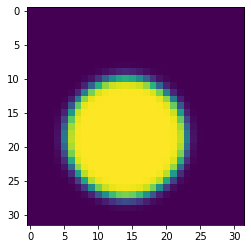

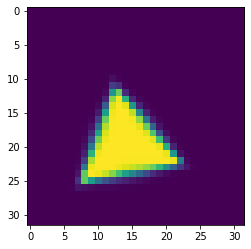

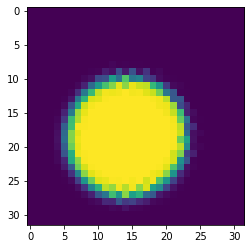

In [123]:
def imshow(x):
    plt.imshow(x[1, 0].detach().cpu())
imshow(batch_full_A)
plt.show()
imshow(batch_full_B)


plt.show()
imshow(net.warped_image_A)

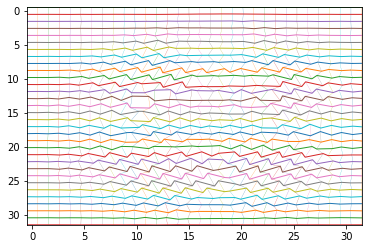

In [124]:
import visualize
visualize.show_as_grid(net.phi_AB_vectorfield[i])
i += 1

In [37]:
i = 0

In [158]:
D = 256

In [171]:
n_components=512